<a href="https://colab.research.google.com/github/nena00s/Capstone-Market-Segmentation-with-Neural-Networks/blob/main/Bank_Marketing.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:

# IMPORTANT: RUN THIS CELL IN ORDER TO IMPORT YOUR KAGGLE DATA SOURCES
# TO THE CORRECT LOCATION (/kaggle/input) IN YOUR NOTEBOOK,
# THEN FEEL FREE TO DELETE THIS CELL.
# NOTE: THIS NOTEBOOK ENVIRONMENT DIFFERS FROM KAGGLE'S PYTHON
# ENVIRONMENT SO THERE MAY BE MISSING LIBRARIES USED BY YOUR
# NOTEBOOK.

import os
import sys
from tempfile import NamedTemporaryFile
from urllib.request import urlopen
from urllib.parse import unquote, urlparse
from urllib.error import HTTPError
from zipfile import ZipFile
import tarfile
import shutil

CHUNK_SIZE = 40960
DATA_SOURCE_MAPPING = 'bank-marketing:https%3A%2F%2Fstorage.googleapis.com%2Fkaggle-data-sets%2F30368%2F38700%2Fbundle%2Farchive.zip%3FX-Goog-Algorithm%3DGOOG4-RSA-SHA256%26X-Goog-Credential%3Dgcp-kaggle-com%2540kaggle-161607.iam.gserviceaccount.com%252F20240425%252Fauto%252Fstorage%252Fgoog4_request%26X-Goog-Date%3D20240425T025751Z%26X-Goog-Expires%3D259200%26X-Goog-SignedHeaders%3Dhost%26X-Goog-Signature%3D527a625525d33eb92b101ad265428c021e4e69c80aa3033e4cffc943736ac0cb807685cba81b2657fc4ff82854bdd0c633b962c9f2b147a2715ac01d58840137d0c45b70d81318d3c9443c23573287e547f230f420db0ff3d7ccf7725dd2d001446da00ea2ab2b41f112faa18d2ec772b15411b22ded35d22e93d1b30dfefe7053939ea13d12f256300ea42945a2c9196317e2853f7b54cf91de102e0fa173169c2dee46c352d9c454d2e3998dfd64c191713dd11413b898534bec79ae8c678c45ea54cdae688a900bafb60d641e189ab67bdb444f1f302b317fa8adf7e8ce9abba9dd1ee8a186b7e8b317147f7448f71cbf6d925e2d3276eb745cba68ad852d'

KAGGLE_INPUT_PATH='/kaggle/input'
KAGGLE_WORKING_PATH='/kaggle/working'
KAGGLE_SYMLINK='kaggle'

!umount /kaggle/input/ 2> /dev/null
shutil.rmtree('/kaggle/input', ignore_errors=True)
os.makedirs(KAGGLE_INPUT_PATH, 0o777, exist_ok=True)
os.makedirs(KAGGLE_WORKING_PATH, 0o777, exist_ok=True)

try:
  os.symlink(KAGGLE_INPUT_PATH, os.path.join("..", 'input'), target_is_directory=True)
except FileExistsError:
  pass
try:
  os.symlink(KAGGLE_WORKING_PATH, os.path.join("..", 'working'), target_is_directory=True)
except FileExistsError:
  pass

for data_source_mapping in DATA_SOURCE_MAPPING.split(','):
    directory, download_url_encoded = data_source_mapping.split(':')
    download_url = unquote(download_url_encoded)
    filename = urlparse(download_url).path
    destination_path = os.path.join(KAGGLE_INPUT_PATH, directory)
    try:
        with urlopen(download_url) as fileres, NamedTemporaryFile() as tfile:
            total_length = fileres.headers['content-length']
            print(f'Downloading {directory}, {total_length} bytes compressed')
            dl = 0
            data = fileres.read(CHUNK_SIZE)
            while len(data) > 0:
                dl += len(data)
                tfile.write(data)
                done = int(50 * dl / int(total_length))
                sys.stdout.write(f"\r[{'=' * done}{' ' * (50-done)}] {dl} bytes downloaded")
                sys.stdout.flush()
                data = fileres.read(CHUNK_SIZE)
            if filename.endswith('.zip'):
              with ZipFile(tfile) as zfile:
                zfile.extractall(destination_path)
            else:
              with tarfile.open(tfile.name) as tarfile:
                tarfile.extractall(destination_path)
            print(f'\nDownloaded and uncompressed: {directory}')
    except HTTPError as e:
        print(f'Failed to load (likely expired) {download_url} to path {destination_path}')
        continue
    except OSError as e:
        print(f'Failed to load {download_url} to path {destination_path}')
        continue

print('Data source import complete.')


[==================================================] 402740 bytes downloaded
Downloaded and uncompressed: bank-marketing
Data source import complete.


In this project, you will build a neural network model that can segment markets based on demographics, behavior, and other relevant factors. You will start by exploring a dataset of customer data, such as the Online Retail Dataset or the Bank Marketing Dataset, and performing EDA to gain insights into the data. You will analyze the correlation between different features and identify any outliers or missing values that need to be handled. Datasets:- Bank Marketing Data: https://www.kaggle.com/datasets/henriqueyamahata/bank-marketing Online Retail Data: https://www.kaggle.com/datasets/carrie1/ecommerce-data

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
import keras
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from imblearn.over_sampling import RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler
import torch
from torch import nn
import warnings
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import MinMaxScaler

In [ ]:
data=pd.read_csv('/kaggle/input/bank-marketing/bank-additional-full.csv',sep=';')
data.head()

,age,job,marital,education,default,housing,loan,contact,month,day_of_week,...,campaign,pdays,previous,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,y
0,56,housemaid,married,basic.4y,no,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
1,57,services,married,high.school,unknown,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
2,37,services,married,high.school,no,yes,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
3,40,admin.,married,basic.6y,no,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
4,56,services,married,high.school,no,no,yes,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no


In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 41188 entries, 0 to 41187
Data columns (total 21 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   age             41188 non-null  int64  
 1   job             41188 non-null  object 
 2   marital         41188 non-null  object 
 3   education       41188 non-null  object 
 4   default         41188 non-null  object 
 5   housing         41188 non-null  object 
 6   loan            41188 non-null  object 
 7   contact         41188 non-null  object 
 8   month           41188 non-null  object 
 9   day_of_week     41188 non-null  object 
 10  duration        41188 non-null  int64  
 11  campaign        41188 non-null  int64  
 12  pdays           41188 non-null  int64  
 13  previous        41188 non-null  int64  
 14  poutcome        41188 non-null  object 
 15  emp.var.rate    41188 non-null  float64
 16  cons.price.idx  41188 non-null  float64
 17  cons.conf.idx   41188 non-null 

In [ ]:
data.isna().sum()

age               0
job               0
marital           0
education         0
default           0
housing           0
loan              0
contact           0
month             0
day_of_week       0
duration          0
campaign          0
pdays             0
previous          0
poutcome          0
emp.var.rate      0
cons.price.idx    0
cons.conf.idx     0
euribor3m         0
nr.employed       0
y                 0
dtype: int64

In [ ]:
data.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
age,41188.0,40.024060,10.421250,17.000,32.000,38.000,47.000,98.000
duration,41188.0,258.285010,259.279249,0.000,102.000,180.000,319.000,4918.000
campaign,41188.0,2.567593,2.770014,1.000,1.000,2.000,3.000,56.000
pdays,41188.0,962.475454,186.910907,0.000,999.000,999.000,999.000,999.000
previous,41188.0,0.172963,0.494901,0.000,0.000,0.000,0.000,7.000
emp.var.rate,41188.0,0.081886,1.570960,-3.400,-1.800,1.100,1.400,1.400
cons.price.idx,41188.0,93.575664,0.578840,92.201,93.075,93.749,93.994,94.767
cons.conf.idx,41188.0,-40.502600,4.628198,-50.800,-42.700,-41.800,-36.400,-26.900
euribor3m,41188.0,3.621291,1.734447,0.634,1.344,4.857,4.961,5.045
nr.employed,41188.0,5167.035911,72.251528,4963.600,5099.100,5191.000,5228.100,5228.100


In [ ]:
data.describe(include='object').transpose()

,count,unique,top,freq
job,41188,12,admin.,10422
marital,41188,4,married,24928
education,41188,8,university.degree,12168
default,41188,3,no,32588
housing,41188,3,yes,21576
loan,41188,3,no,33950
contact,41188,2,cellular,26144
month,41188,10,may,13769
day_of_week,41188,5,thu,8623
poutcome,41188,3,nonexistent,35563


In [ ]:
data.shape

(41188, 21)

In [ ]:
data.duplicated?

In [ ]:
data[data.duplicated(keep=False)]

,age,job,marital,education,default,housing,loan,contact,month,day_of_week,...,campaign,pdays,previous,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,y
1265,39,blue-collar,married,basic.6y,no,no,no,telephone,may,thu,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.855,5191.0,no
1266,39,blue-collar,married,basic.6y,no,no,no,telephone,may,thu,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.855,5191.0,no
12260,36,retired,married,unknown,no,no,no,telephone,jul,thu,...,1,999,0,nonexistent,1.4,93.918,-42.7,4.966,5228.1,no
12261,36,retired,married,unknown,no,no,no,telephone,jul,thu,...,1,999,0,nonexistent,1.4,93.918,-42.7,4.966,5228.1,no
14155,27,technician,single,professional.course,no,no,no,cellular,jul,mon,...,2,999,0,nonexistent,1.4,93.918,-42.7,4.962,5228.1,no
14234,27,technician,single,professional.course,no,no,no,cellular,jul,mon,...,2,999,0,nonexistent,1.4,93.918,-42.7,4.962,5228.1,no
16819,47,technician,divorced,high.school,no,yes,no,cellular,jul,thu,...,3,999,0,nonexistent,1.4,93.918,-42.7,4.962,5228.1,no
16956,47,technician,divorced,high.school,no,yes,no,cellular,jul,thu,...,3,999,0,nonexistent,1.4,93.918,-42.7,4.962,5228.1,no
18464,32,technician,single,professional.course,no,yes,no,cellular,jul,thu,...,1,999,0,nonexistent,1.4,93.918,-42.7,4.968,5228.1,no
18465,32,technician,single,professional.course,no,yes,no,cellular,jul,thu,...,1,999,0,nonexistent,1.4,93.918,-42.7,4.968,5228.1,no


In [ ]:
data.drop_duplicates(inplace=True)
data[data.duplicated(keep=False)]

,age,job,marital,education,default,housing,loan,contact,month,day_of_week,...,campaign,pdays,previous,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,y


In [ ]:
data.shape

(41176, 21)

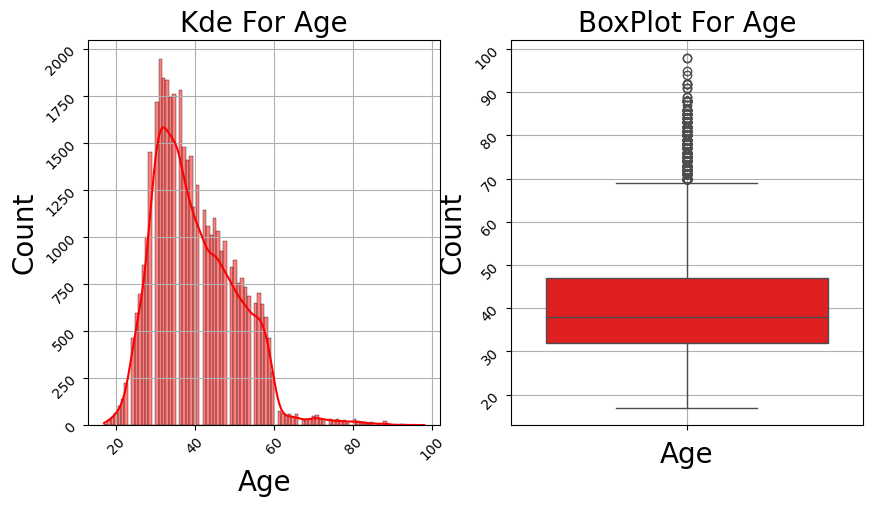

In [ ]:
plt.figure(figsize=(10,5))
plt.subplot(1,2,1)
sns.histplot(data.age,kde=True,color='r')
plt.grid(True)
plt.xticks(rotation=45)
plt.yticks(rotation=45)
plt.title('Kde For Age',fontsize=20)
plt.xlabel('Age',fontsize=20)
plt.ylabel('Count',fontsize=20)
plt.subplot(1,2,2)
sns.boxplot(data=data.age,color='r')
plt.grid(True)
plt.xticks(rotation=45)
plt.yticks(rotation=45)
plt.title('BoxPlot For Age',fontsize=20)
plt.xlabel('Age',fontsize=20)
plt.ylabel('Count',fontsize=20)
plt.show()

In [ ]:
q25,q75=np.percentile(data.age,(25,75))
qr=q75-q25
max=q75+qr*1.5
min=q25-qr*1.5
data.age[data.age>max]=max
data.age[data.age<min]=min
q25,q75,qr,max,min

<ipython-input-14-274cb3a5e372>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data.age[data.age>max]=max


(32.0, 47.0, 15.0, 69.5, 9.5)

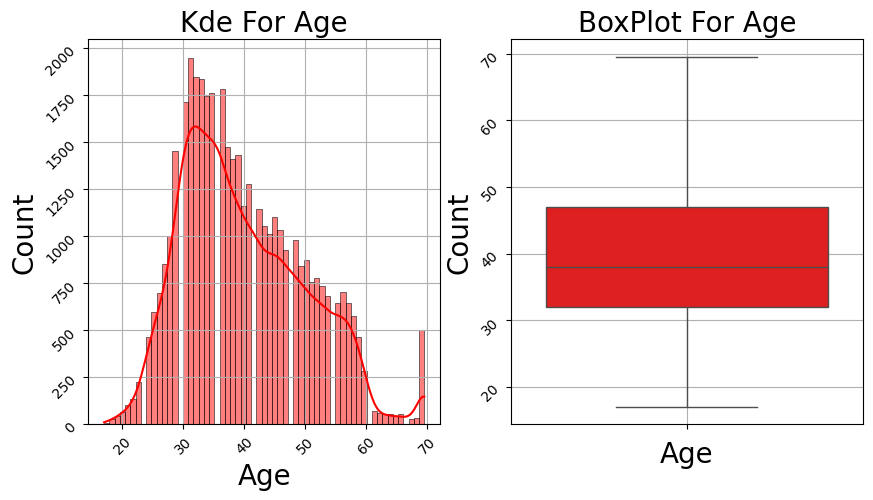

In [ ]:
plt.figure(figsize=(10,5))
plt.subplot(1,2,1)
sns.histplot(data.age,kde=True,color='r')
plt.grid(True)
plt.xticks(rotation=45)
plt.yticks(rotation=45)
plt.title('Kde For Age',fontsize=20)
plt.xlabel('Age',fontsize=20)
plt.ylabel('Count',fontsize=20)
plt.subplot(1,2,2)
sns.boxplot(data=data.age,color='r')
plt.grid(True)
plt.xticks(rotation=45)
plt.yticks(rotation=45)
plt.title('BoxPlot For Age',fontsize=20)
plt.xlabel('Age',fontsize=20)
plt.ylabel('Count',fontsize=20)
plt.show()

In [ ]:
data.job.value_counts()

job
admin.           10419
blue-collar       9253
technician        6739
services          3967
management        2924
retired           1718
entrepreneur      1456
self-employed     1421
housemaid         1060
unemployed        1014
student            875
unknown            330
Name: count, dtype: int64

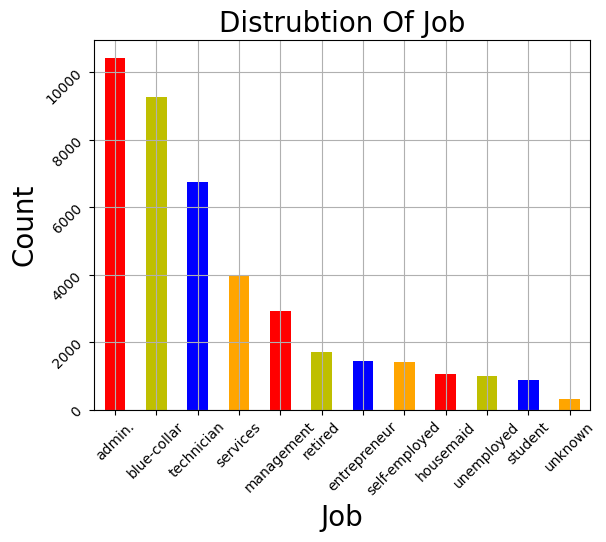

In [ ]:
data.job.value_counts().plot.bar(color=['r','y','b','orange'])
plt.grid(True)
plt.title('Distrubtion Of Job',fontsize=20)
plt.xlabel('Job',fontsize=20)
plt.ylabel('Count',fontsize=20)
plt.xticks(rotation=45)
plt.yticks(rotation=45)
plt.show()

In [ ]:
pd.crosstab(data.y,data.job)

job,admin.,blue-collar,entrepreneur,housemaid,management,retired,self-employed,services,student,technician,unemployed,unknown
y,,,,,,,,,,,,
no,9068,8615,1332,954,2596,1284,1272,3644,600,6009,870,293
yes,1351,638,124,106,328,434,149,323,275,730,144,37


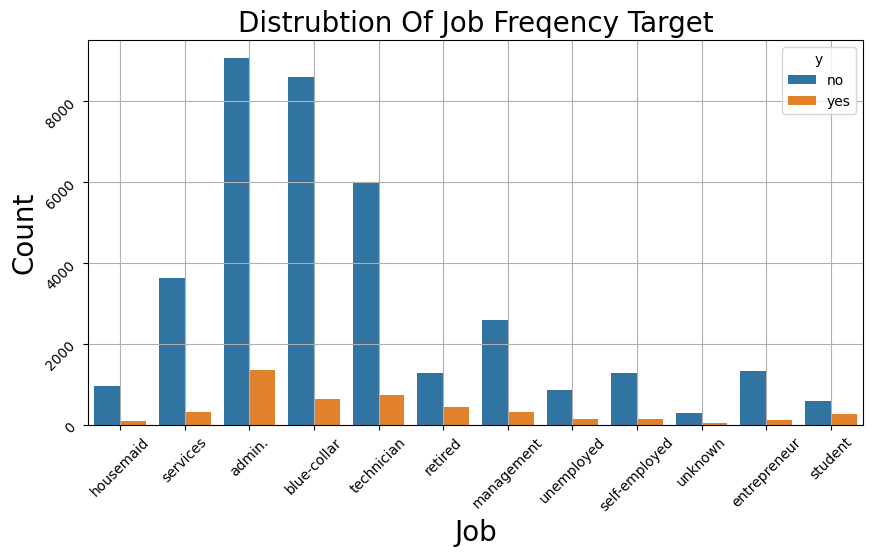

In [ ]:
plt.figure(figsize=(10,5))
sns.countplot(x='job',hue='y',data=data)
plt.grid(True)
plt.title('Distrubtion Of Job Freqency Target',fontsize=20)
plt.xlabel('Job',fontsize=20)
plt.ylabel('Count',fontsize=20)
plt.xticks(rotation=45)
plt.yticks(rotation=45)
plt.show()

In [ ]:
pd.crosstab(data.loan,data.job)

job,admin.,blue-collar,entrepreneur,housemaid,management,retired,self-employed,services,student,technician,unemployed,unknown
loan,,,,,,,,,,,,
no,8482,7647,1214,877,2414,1434,1186,3265,710,5603,838,268
unknown,227,240,36,29,71,44,40,101,23,147,27,5
yes,1710,1366,206,154,439,240,195,601,142,989,149,57


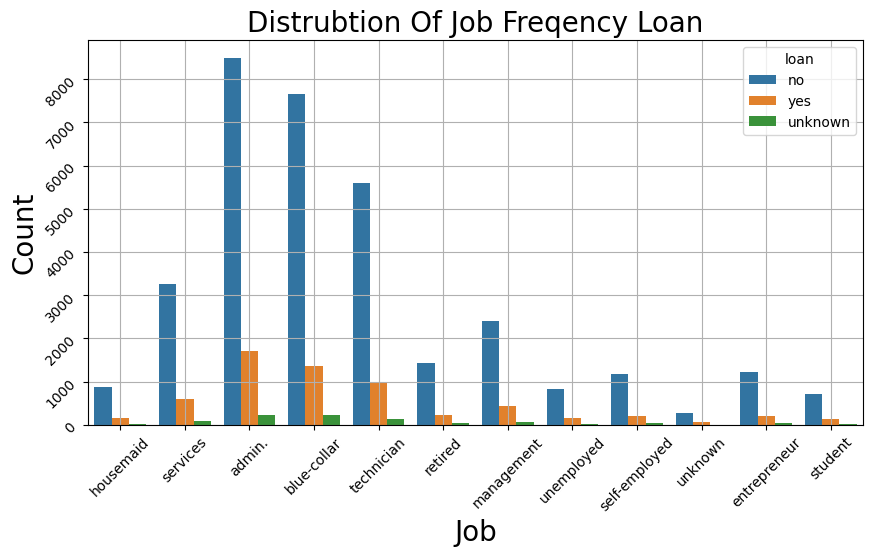

In [ ]:
plt.figure(figsize=(10,5))
sns.countplot(x='job',hue='loan',data=data)
plt.grid(True)
plt.title('Distrubtion Of Job Freqency Loan',fontsize=20)
plt.xlabel('Job',fontsize=20)
plt.ylabel('Count',fontsize=20)
plt.xticks(rotation=45)
plt.yticks(rotation=45)
plt.show()

In [ ]:
data.groupby(['y','loan','job'])['job'].count()

y    loan  job         
no   no    admin.          7364
           blue-collar     7108
           entrepreneur    1104
           housemaid        789
           management      2134
                           ... 
yes  yes   services          52
           student           55
           technician       109
           unemployed        18
           unknown            5
Name: job, Length: 71, dtype: int64

In [ ]:
pd.crosstab(data.contact,data.job)

job,admin.,blue-collar,entrepreneur,housemaid,management,retired,self-employed,services,student,technician,unemployed,unknown
contact,,,,,,,,,,,,
cellular,7123,5090,855,640,1902,1231,893,2309,671,4633,620,168
telephone,3296,4163,601,420,1022,487,528,1658,204,2106,394,162


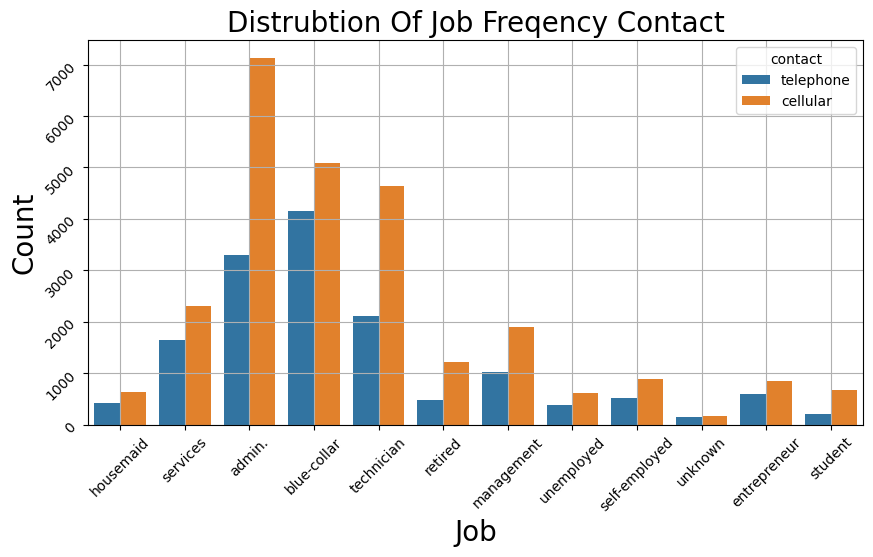

In [ ]:
plt.figure(figsize=(10,5))
sns.countplot(x='job',hue='contact',data=data)
plt.grid(True)
plt.title('Distrubtion Of Job Freqency Contact',fontsize=20)
plt.xlabel('Job',fontsize=20)
plt.ylabel('Count',fontsize=20)
plt.xticks(rotation=45)
plt.yticks(rotation=45)
plt.show()

In [ ]:
pd.crosstab(data.marital,data.job)

job,admin.,blue-collar,entrepreneur,housemaid,management,retired,self-employed,services,student,technician,unemployed,unknown
marital,,,,,,,,,,,,
divorced,1280,728,179,161,331,348,133,532,9,773,124,13
married,5250,6686,1071,777,2089,1273,904,2293,41,3669,634,234
single,3875,1825,203,119,501,92,379,1136,824,2285,251,74
unknown,14,14,3,3,3,5,5,6,1,12,5,9


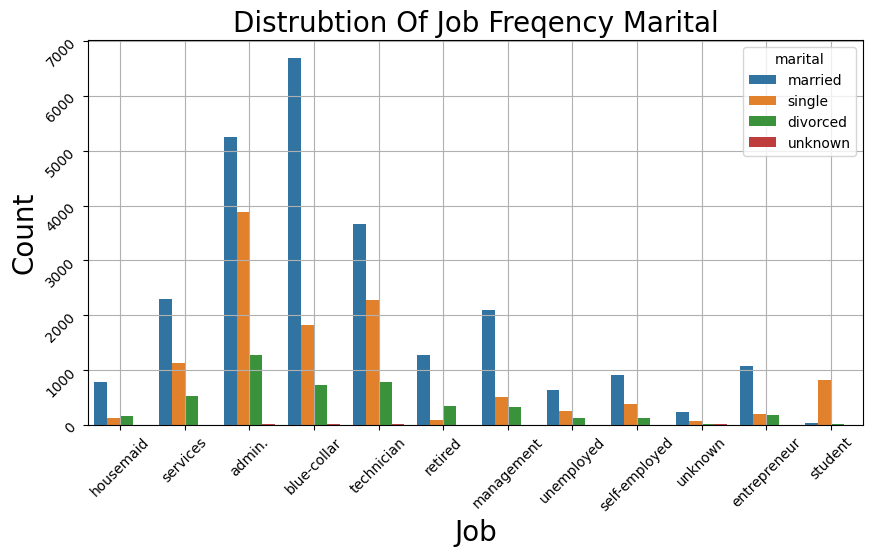

In [ ]:
plt.figure(figsize=(10,5))
sns.countplot(x='job',hue='marital',data=data)
plt.grid(True)
plt.title('Distrubtion Of Job Freqency Marital',fontsize=20)
plt.xlabel('Job',fontsize=20)
plt.ylabel('Count',fontsize=20)
plt.xticks(rotation=45)
plt.yticks(rotation=45)
plt.show()

In [ ]:
pd.crosstab(data.education,data.job)

job,admin.,blue-collar,entrepreneur,housemaid,management,retired,self-employed,services,student,technician,unemployed,unknown
education,,,,,,,,,,,,
basic.4y,77,2318,137,474,100,597,93,132,26,58,112,52
basic.6y,151,1425,71,77,85,75,25,226,13,87,34,22
basic.9y,499,3623,210,94,166,145,220,388,99,384,186,31
high.school,3329,878,234,174,298,276,118,2680,357,872,259,37
illiterate,1,8,2,1,0,3,3,0,0,0,0,0
professional.course,363,453,135,59,89,241,168,218,43,3317,142,12
university.degree,5750,94,610,139,2063,284,765,173,170,1809,262,45
unknown,249,454,57,42,123,97,29,150,167,212,19,131


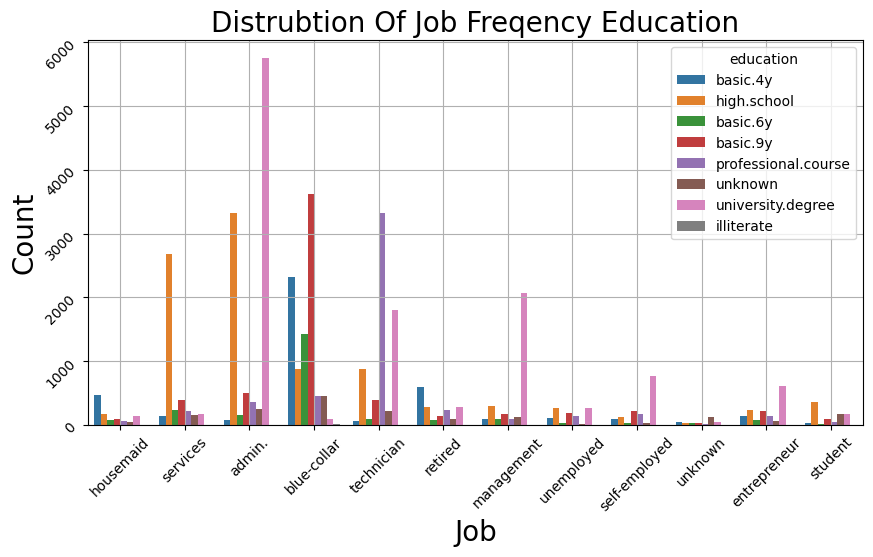

In [ ]:
plt.figure(figsize=(10,5))
sns.countplot(x='job',hue='education',data=data)
plt.grid(True)
plt.title('Distrubtion Of Job Freqency Education',fontsize=20)
plt.xlabel('Job',fontsize=20)
plt.ylabel('Count',fontsize=20)
plt.xticks(rotation=45)
plt.yticks(rotation=45)
plt.show()

In [ ]:
pd.crosstab(data.default,data.job)

job,admin.,blue-collar,entrepreneur,housemaid,management,retired,self-employed,services,student,technician,unemployed,unknown
default,,,,,,,,,,,,
no,9126,6087,1155,741,2466,1325,1139,3052,771,5761,776,178
unknown,1293,3166,301,319,458,393,282,915,104,976,237,152
yes,0,0,0,0,0,0,0,0,0,2,1,0


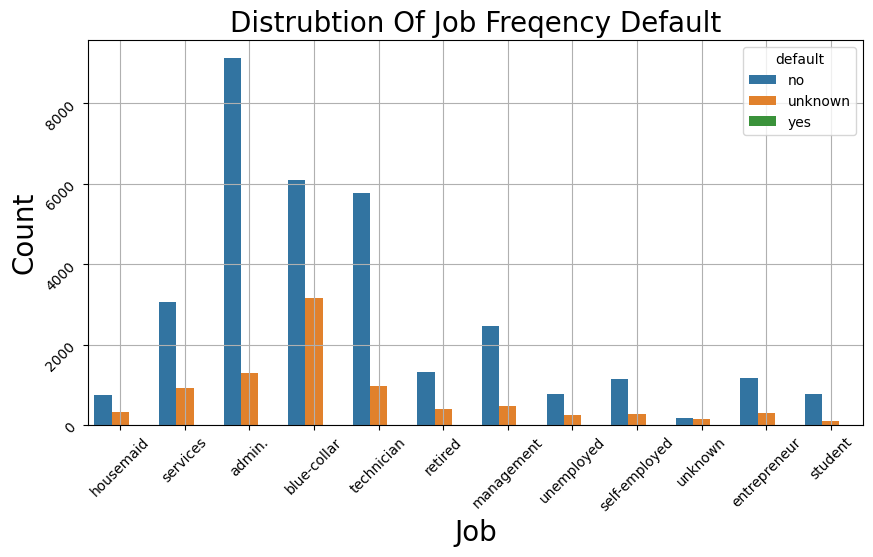

In [ ]:
plt.figure(figsize=(10,5))
sns.countplot(x='job',hue='default',data=data)
plt.grid(True)
plt.title('Distrubtion Of Job Freqency Default',fontsize=20)
plt.xlabel('Job',fontsize=20)
plt.ylabel('Count',fontsize=20)
plt.xticks(rotation=45)
plt.yticks(rotation=45)
plt.show()

In [ ]:
pd.crosstab(data.housing,data.job)

job,admin.,blue-collar,entrepreneur,housemaid,management,retired,self-employed,services,student,technician,unemployed,unknown
housing,,,,,,,,,,,,
no,4634,4303,641,491,1363,782,641,1817,381,2979,430,153
unknown,227,240,36,29,71,44,40,101,23,147,27,5
yes,5558,4710,779,540,1490,892,740,2049,471,3613,557,172


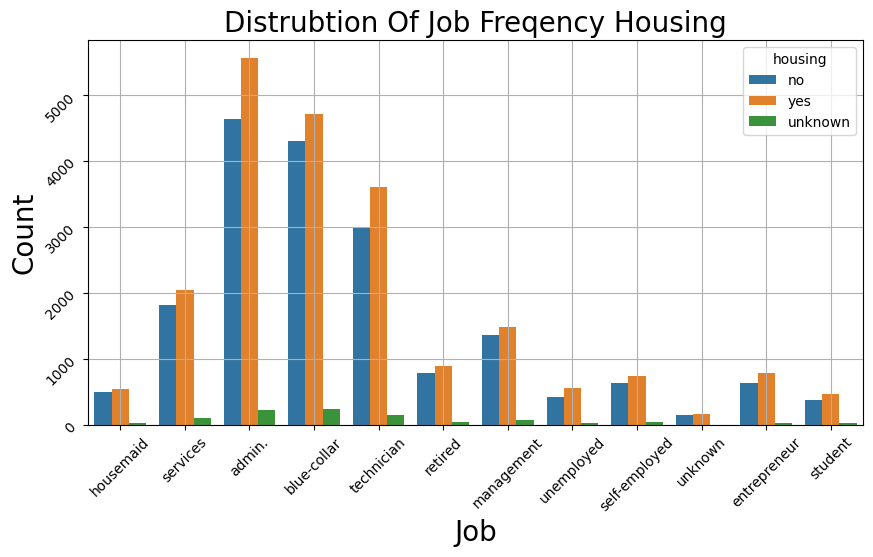

In [ ]:
plt.figure(figsize=(10,5))
sns.countplot(x='job',hue='housing',data=data)
plt.grid(True)
plt.title('Distrubtion Of Job Freqency Housing',fontsize=20)
plt.xlabel('Job',fontsize=20)
plt.ylabel('Count',fontsize=20)
plt.xticks(rotation=45)
plt.yticks(rotation=45)
plt.show()

In [ ]:
data.education.value_counts()

education
university.degree      12164
high.school             9512
basic.9y                6045
professional.course     5240
basic.4y                4176
basic.6y                2291
unknown                 1730
illiterate                18
Name: count, dtype: int64

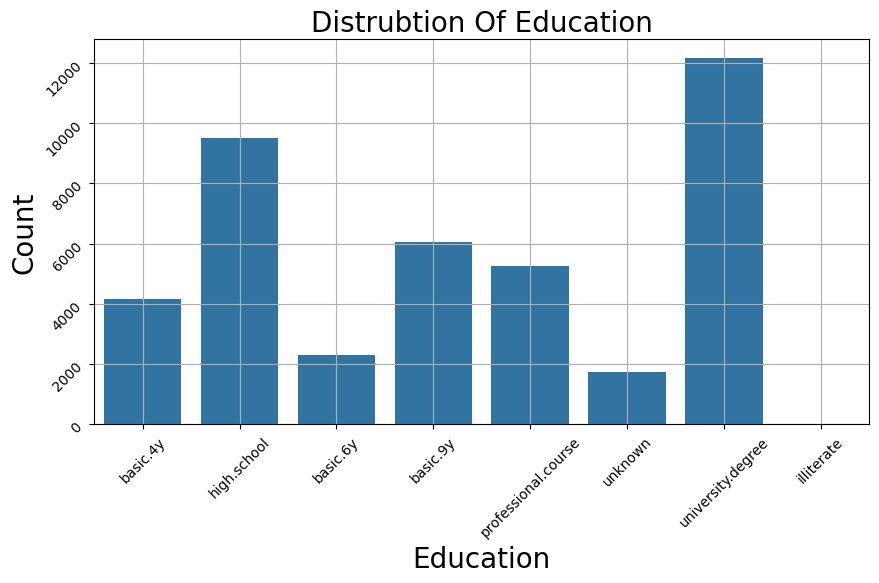

In [ ]:
plt.figure(figsize=(10,5))
sns.countplot(x='education',data=data)
plt.grid(True)
plt.title('Distrubtion Of Education',fontsize=20)
plt.xlabel('Education',fontsize=20)
plt.ylabel('Count',fontsize=20)
plt.xticks(rotation=45)
plt.yticks(rotation=45)
plt.show()

In [ ]:
pd.crosstab(data.y,data.education)

education,basic.4y,basic.6y,basic.9y,high.school,illiterate,professional.course,university.degree,unknown
y,,,,,,,,
no,3748,2103,5572,8481,14,4645,10495,1479
yes,428,188,473,1031,4,595,1669,251


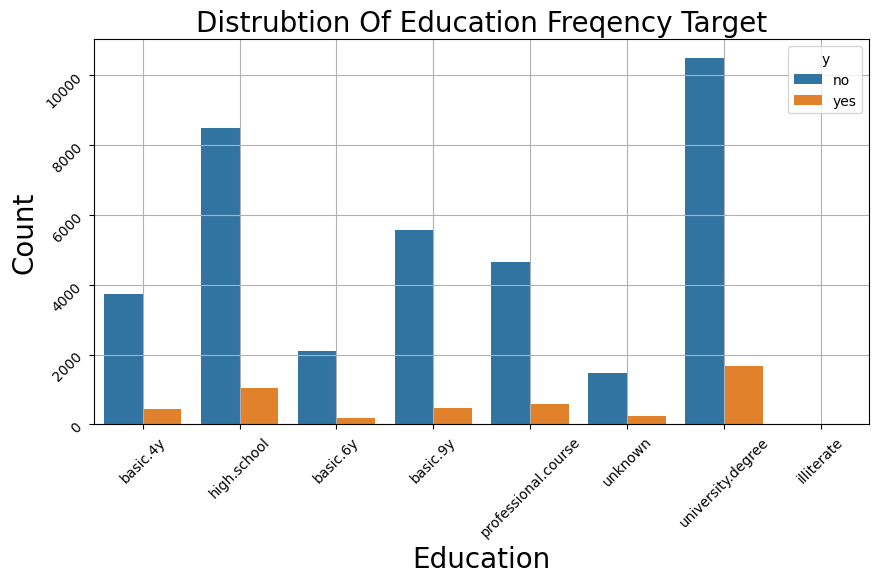

In [ ]:
plt.figure(figsize=(10,5))
sns.countplot(x='education',hue='y',data=data)
plt.grid(True)
plt.title('Distrubtion Of Education Freqency Target',fontsize=20)
plt.xlabel('Education',fontsize=20)
plt.ylabel('Count',fontsize=20)
plt.xticks(rotation=45)
plt.yticks(rotation=45)
plt.show()

In [ ]:
data.marital.value_counts()

marital
married     24921
single      11564
divorced     4611
unknown        80
Name: count, dtype: int64

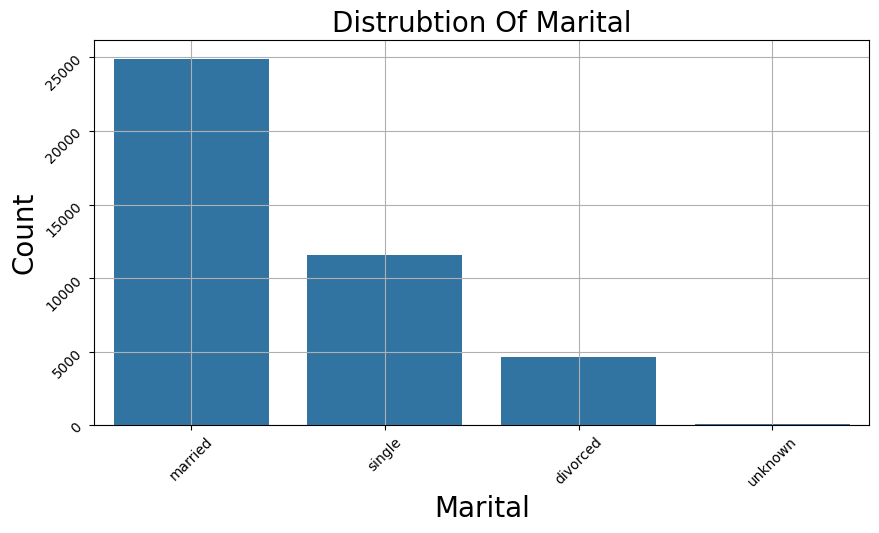

In [ ]:
plt.figure(figsize=(10,5))
sns.countplot(x='marital',data=data)
plt.grid(True)
plt.title('Distrubtion Of Marital',fontsize=20)
plt.xlabel('Marital',fontsize=20)
plt.ylabel('Count',fontsize=20)
plt.xticks(rotation=45)
plt.yticks(rotation=45)
plt.show()

In [ ]:
pd.crosstab(data.y,data.marital)

marital,divorced,married,single,unknown
y,,,,
no,4135,22390,9944,68
yes,476,2531,1620,12


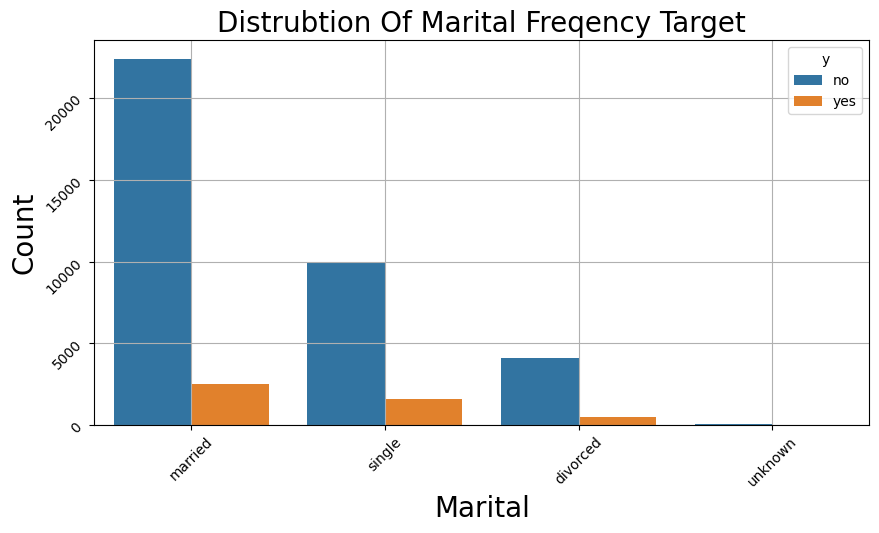

In [ ]:
plt.figure(figsize=(10,5))
sns.countplot(x='marital',hue='y',data=data)
plt.grid(True)
plt.title('Distrubtion Of Marital Freqency Target',fontsize=20)
plt.xlabel('Marital',fontsize=20)
plt.ylabel('Count',fontsize=20)
plt.xticks(rotation=45)
plt.yticks(rotation=45)
plt.show()

In [ ]:
data.loan.value_counts()

loan
no         33938
yes         6248
unknown      990
Name: count, dtype: int64

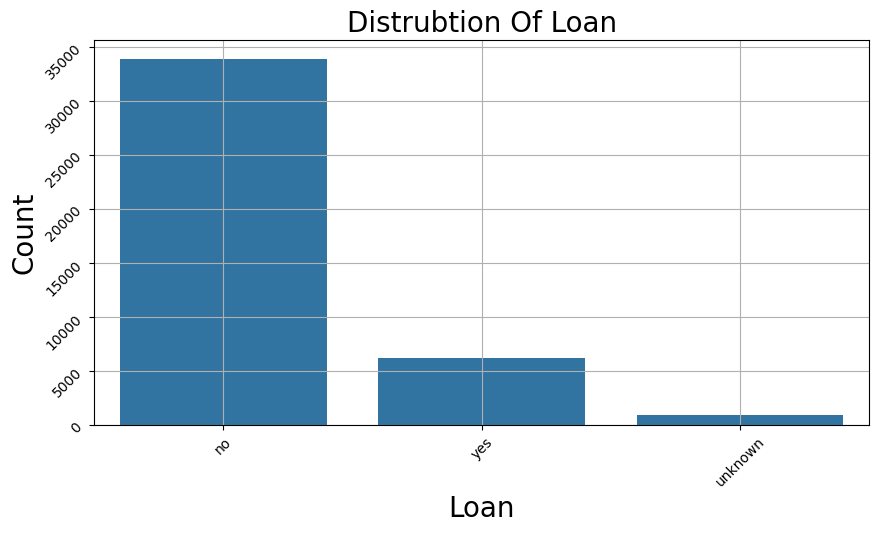

In [ ]:
plt.figure(figsize=(10,5))
sns.countplot(x='loan',data=data)
plt.grid(True)
plt.title('Distrubtion Of Loan',fontsize=20)
plt.xlabel('Loan',fontsize=20)
plt.ylabel('Count',fontsize=20)
plt.xticks(rotation=45)
plt.yticks(rotation=45)
plt.show()

In [ ]:
pd.crosstab(data.y,data.loan)

loan,no,unknown,yes
y,,,
no,30089,883,5565
yes,3849,107,683


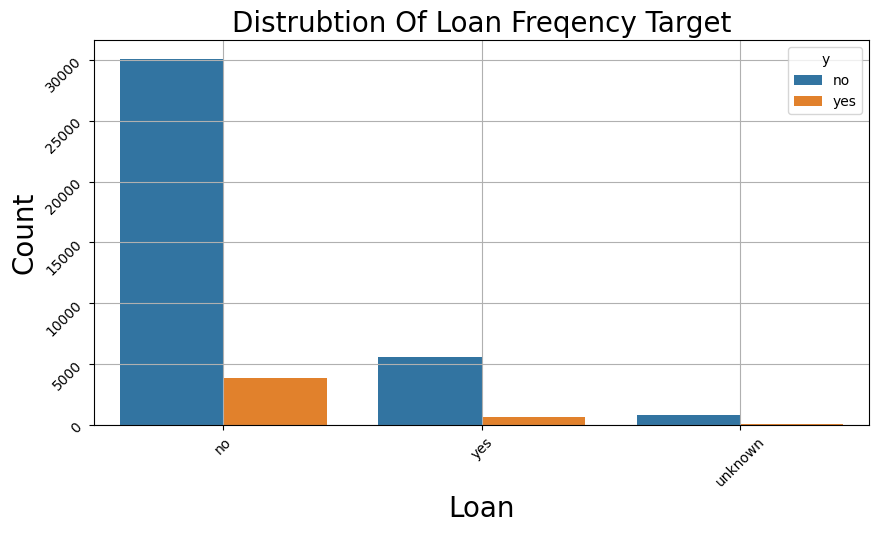

In [ ]:
plt.figure(figsize=(10,5))
sns.countplot(x='loan',hue='y',data=data)
plt.grid(True)
plt.title('Distrubtion Of Loan Freqency Target',fontsize=20)
plt.xlabel('Loan',fontsize=20)
plt.ylabel('Count',fontsize=20)
plt.xticks(rotation=45)
plt.yticks(rotation=45)
plt.show()

In [ ]:
data.default.value_counts()

default
no         32577
unknown     8596
yes            3
Name: count, dtype: int64

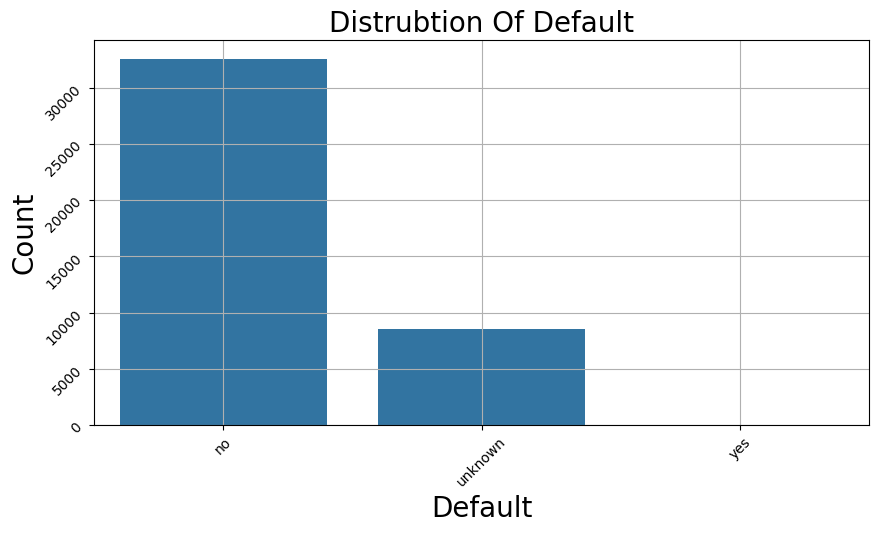

In [ ]:
plt.figure(figsize=(10,5))
sns.countplot(x='default',data=data)
plt.grid(True)
plt.title('Distrubtion Of Default',fontsize=20)
plt.xlabel('Default',fontsize=20)
plt.ylabel('Count',fontsize=20)
plt.xticks(rotation=45)
plt.yticks(rotation=45)
plt.show()

In [ ]:
pd.crosstab(data.y,data.default)

default,no,unknown,yes
y,,,
no,28381,8153,3
yes,4196,443,0


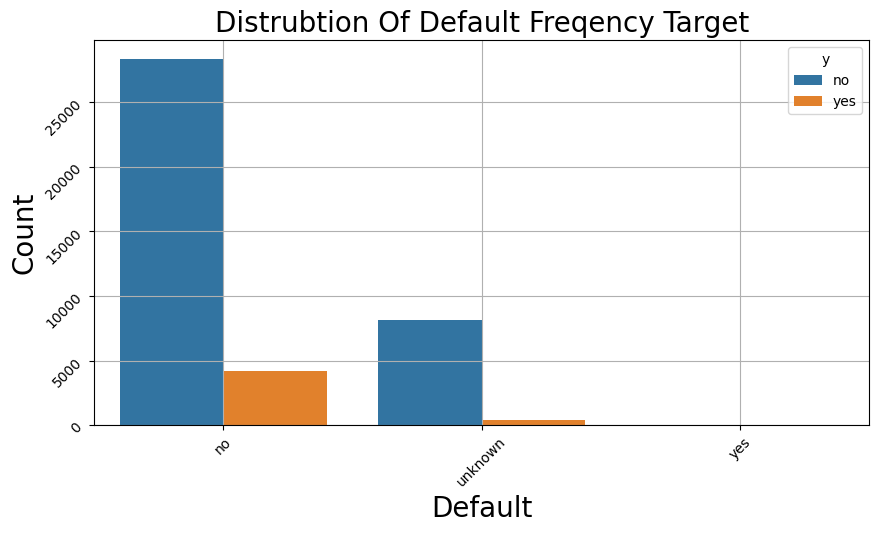

In [ ]:
plt.figure(figsize=(10,5))
sns.countplot(x='default',hue='y',data=data)
plt.grid(True)
plt.title('Distrubtion Of Default Freqency Target',fontsize=20)
plt.xlabel('Default',fontsize=20)
plt.ylabel('Count',fontsize=20)
plt.xticks(rotation=45)
plt.yticks(rotation=45)
plt.show()

In [ ]:
data.contact.value_counts()

contact
cellular     26135
telephone    15041
Name: count, dtype: int64

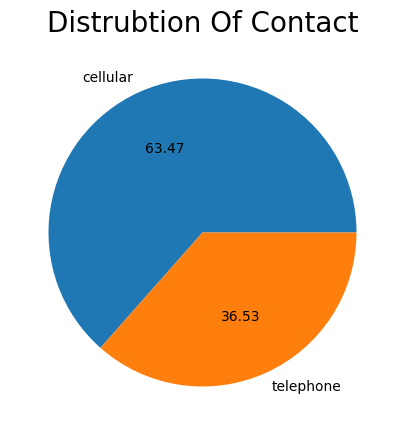

In [ ]:
plt.figure(figsize=(10,5))
plt.pie(data.contact.value_counts().values,labels=data.contact.value_counts().index,
           autopct='%.2f')
plt.title('Distrubtion Of Contact',fontsize=20)
plt.show()

In [ ]:
pd.crosstab(data.y,data.contact)

contact,cellular,telephone
y,,
no,22283,14254
yes,3852,787


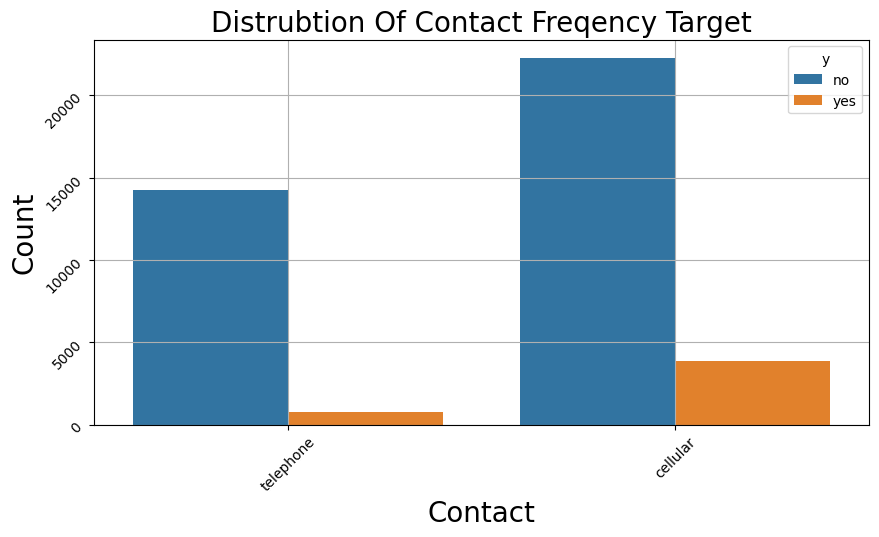

In [ ]:
plt.figure(figsize=(10,5))
sns.countplot(x='contact',hue='y',data=data)
plt.grid(True)
plt.title('Distrubtion Of Contact Freqency Target',fontsize=20)
plt.xlabel('Contact',fontsize=20)
plt.ylabel('Count',fontsize=20)
plt.xticks(rotation=45)
plt.yticks(rotation=45)
plt.show()

In [ ]:
data.y.value_counts()

y
no     36537
yes     4639
Name: count, dtype: int64

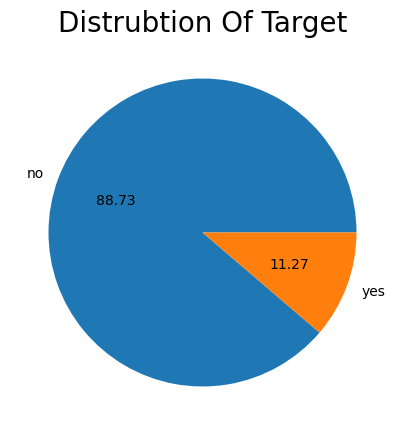

In [ ]:
plt.figure(figsize=(10,5))
plt.pie(data.y.value_counts().values,labels=data.y.value_counts().index,
           autopct='%.2f')
plt.title('Distrubtion Of Target',fontsize=20)
plt.show()

In [ ]:
data.month.value_counts()

month
may    13767
jul     7169
aug     6176
jun     5318
nov     4100
apr     2631
oct      717
sep      570
mar      546
dec      182
Name: count, dtype: int64

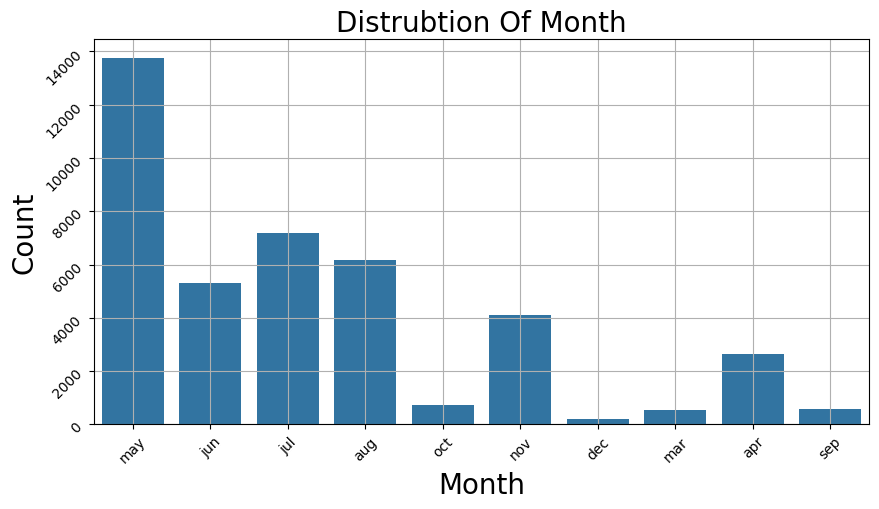

In [ ]:
plt.figure(figsize=(10,5))
sns.countplot(x='month',data=data)
plt.grid(True)
plt.title('Distrubtion Of Month',fontsize=20)
plt.xlabel('Month',fontsize=20)
plt.ylabel('Count',fontsize=20)
plt.xticks(rotation=45)
plt.yticks(rotation=45)
plt.show()

In [ ]:
pd.crosstab(data.y,data.month)

month,apr,aug,dec,jul,jun,mar,may,nov,oct,sep
y,,,,,,,,,,
no,2092,5521,93,6521,4759,270,12881,3684,402,314
yes,539,655,89,648,559,276,886,416,315,256


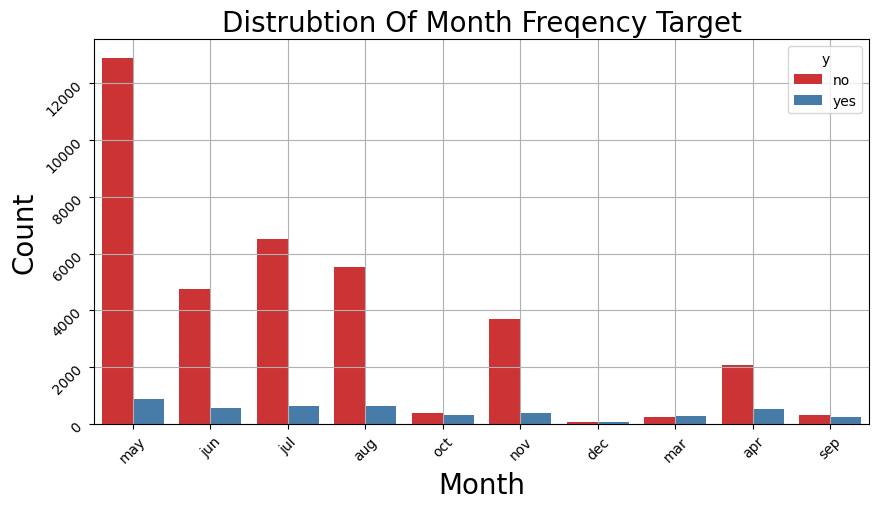

In [ ]:
plt.figure(figsize=(10,5))
sns.countplot(x='month',hue='y',data=data,palette='Set1')
plt.grid(True)
plt.title('Distrubtion Of Month Freqency Target',fontsize=20)
plt.xlabel('Month',fontsize=20)
plt.ylabel('Count',fontsize=20)
plt.xticks(rotation=45)
plt.yticks(rotation=45)
plt.show()

In [ ]:
data.day_of_week.value_counts()

day_of_week
thu    8618
mon    8512
wed    8134
tue    8086
fri    7826
Name: count, dtype: int64

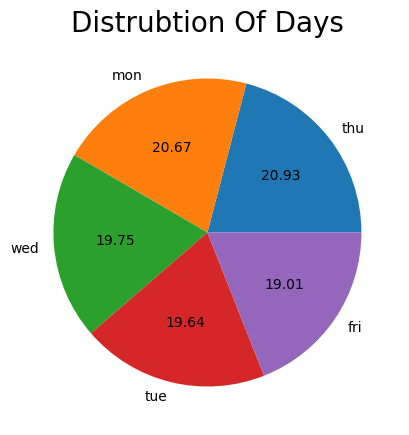

In [ ]:
plt.figure(figsize=(10,5))
plt.pie(data.day_of_week.value_counts().values,labels=data.day_of_week.value_counts().index,
           autopct='%.2f')
plt.title('Distrubtion Of Days',fontsize=20)
plt.show()

In [ ]:
pd.crosstab(data.month,data.day_of_week)

day_of_week,fri,mon,thu,tue,wed
month,,,,,
apr,610,702,768,251,300
aug,1070,1221,1347,1295,1243
dec,24,53,45,25,35
jul,1012,1515,1668,1517,1457
jun,1147,1251,967,970,983
mar,94,143,99,140,70
may,2857,2642,2536,2809,2923
nov,755,766,903,813,863
oct,142,129,163,148,135


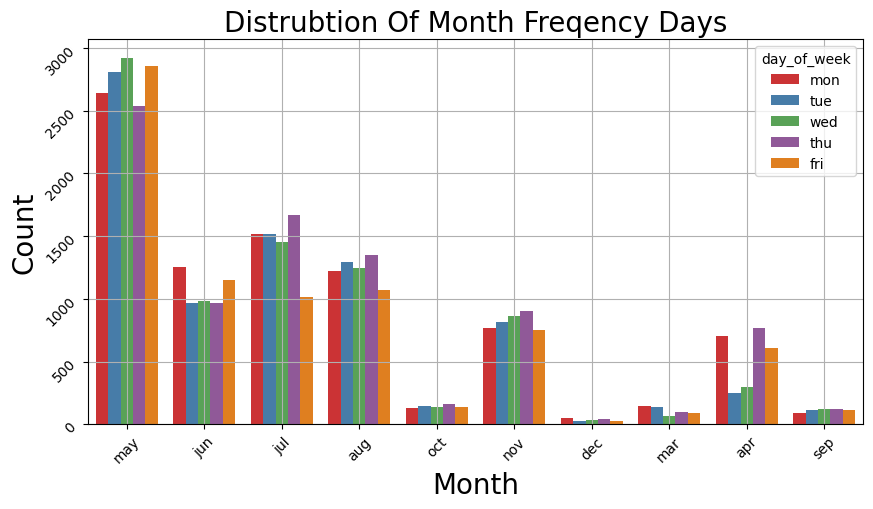

In [ ]:
plt.figure(figsize=(10,5))
sns.countplot(x='month',hue='day_of_week',data=data,palette='Set1')
plt.grid(True)
plt.title('Distrubtion Of Month Freqency Days',fontsize=20)
plt.xlabel('Month',fontsize=20)
plt.ylabel('Count',fontsize=20)
plt.xticks(rotation=45)
plt.yticks(rotation=45)
plt.show()

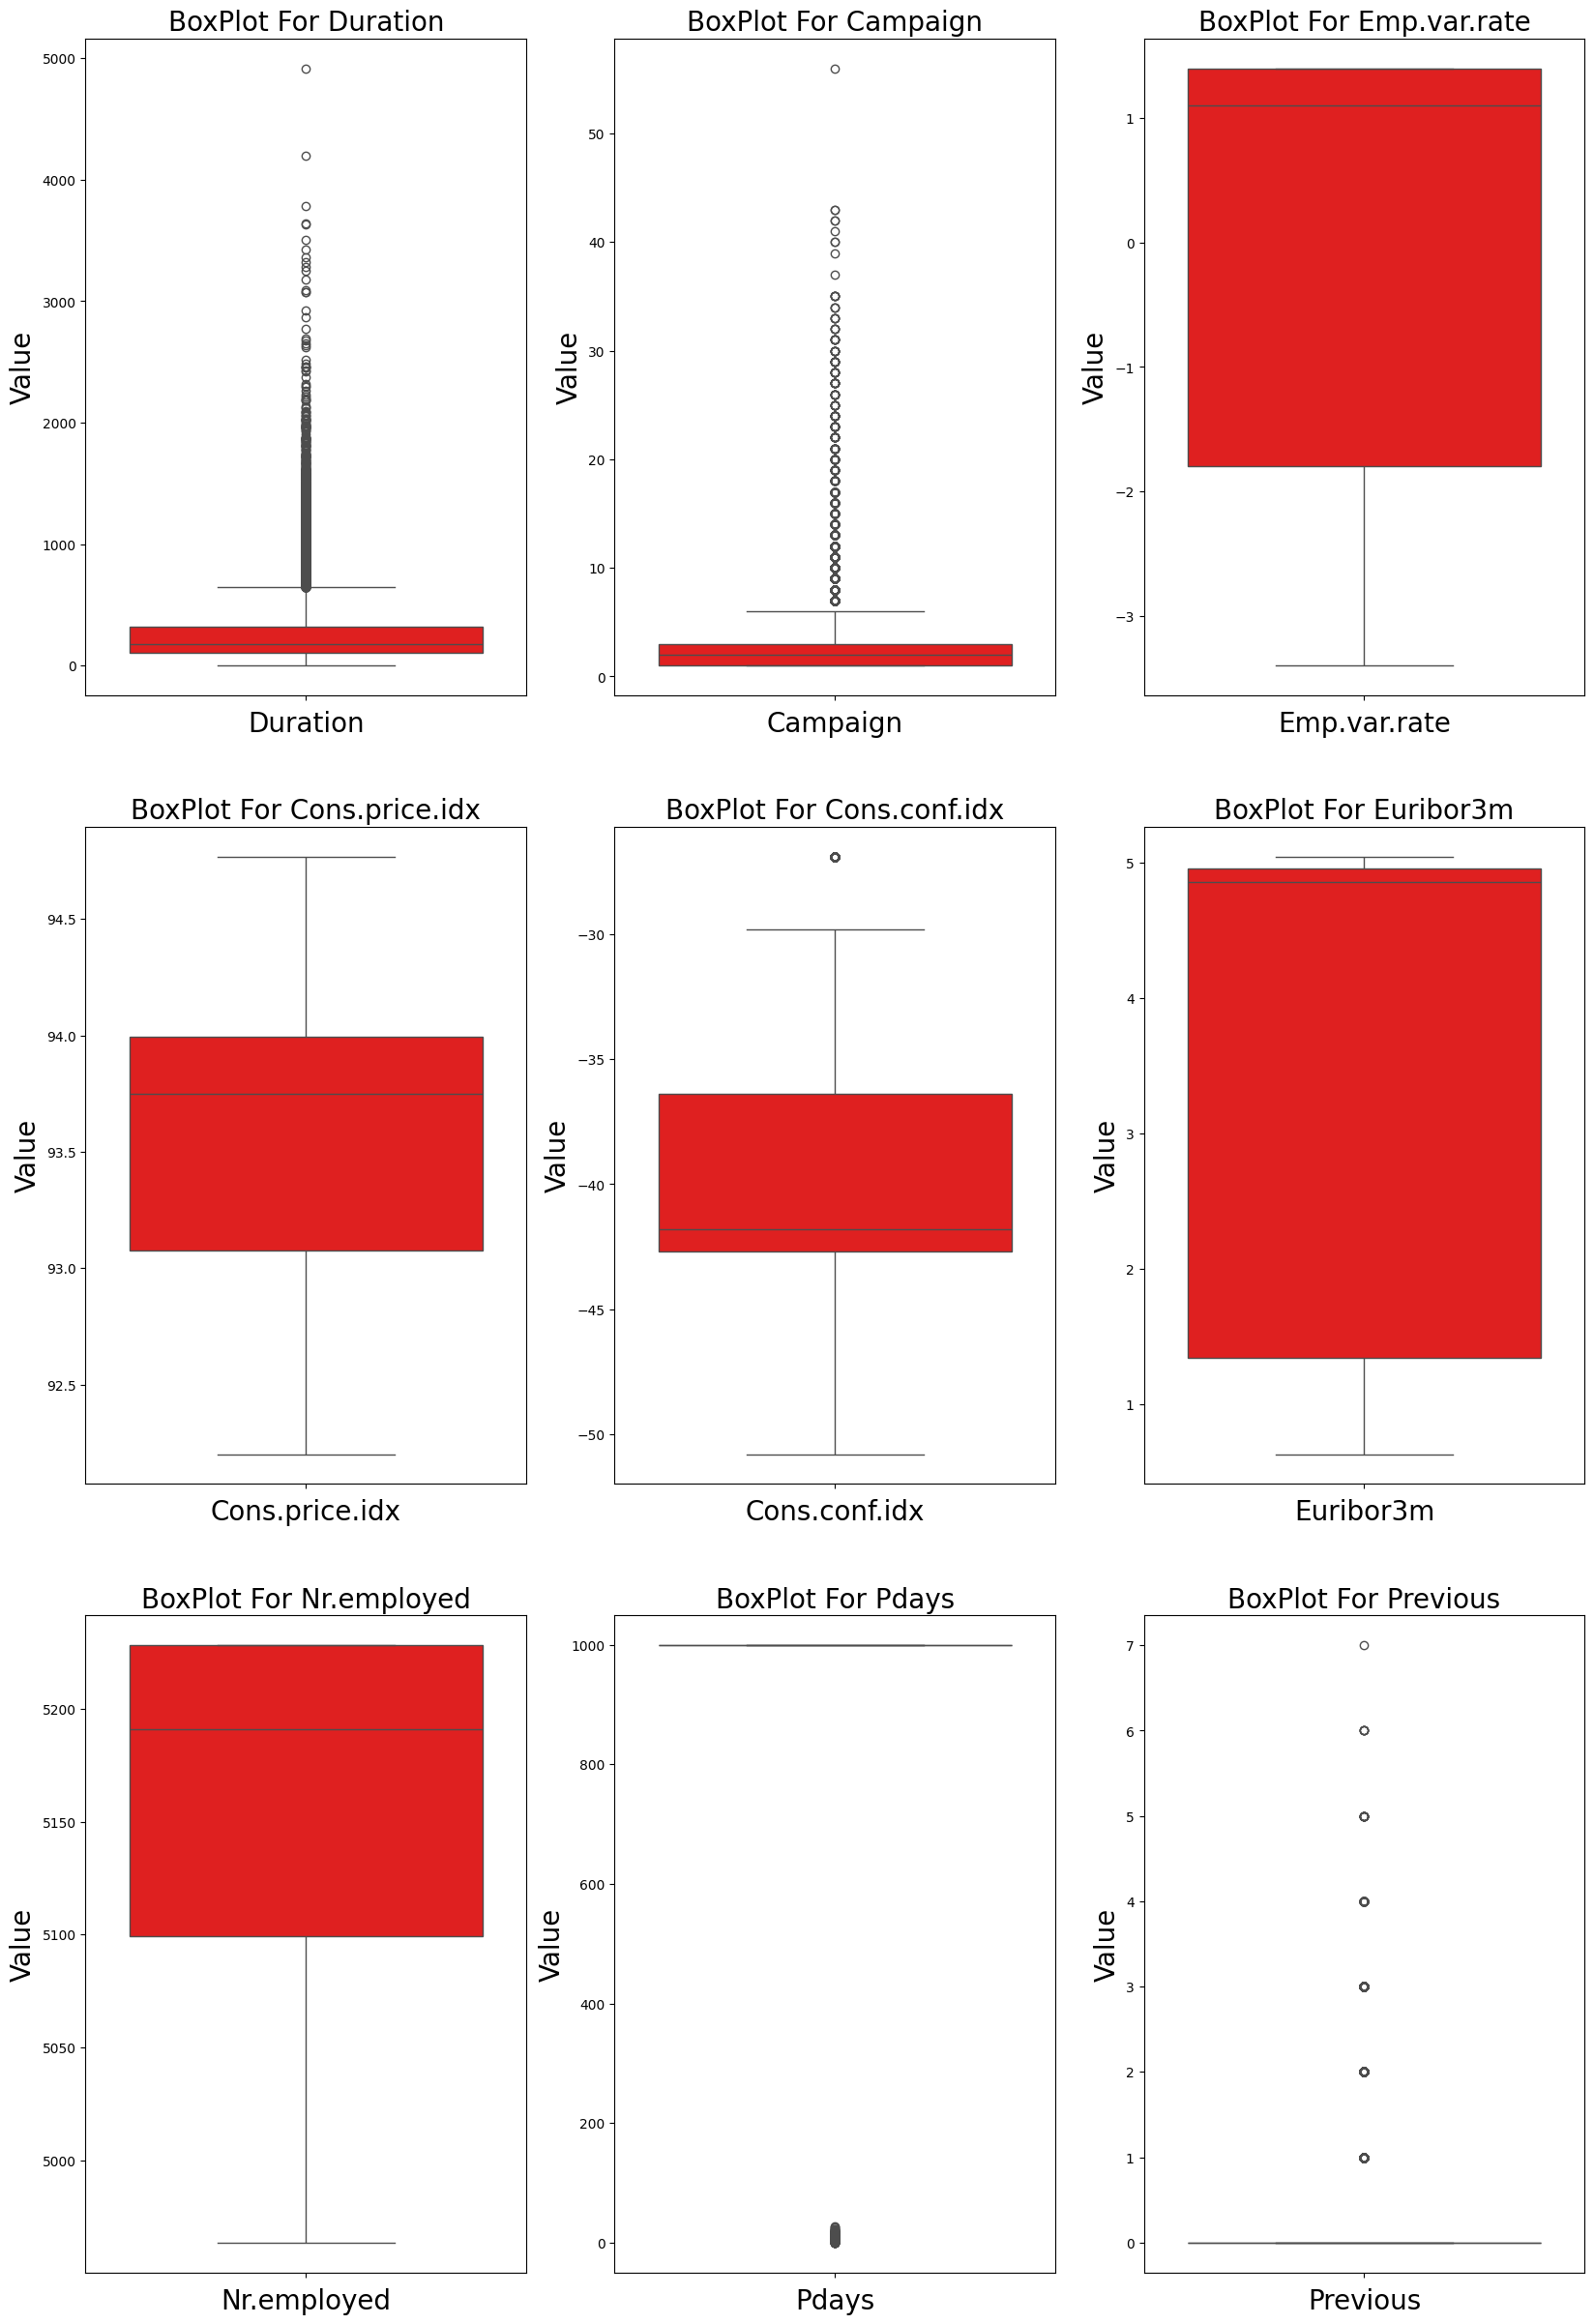

In [ ]:
li=['duration','campaign','emp.var.rate','cons.price.idx',
    'cons.conf.idx','euribor3m','nr.employed','pdays','previous']
plt.figure(figsize=(20,30))
for i,x in enumerate(li):
    plt.subplot(3,3,i+1)
    sns.boxplot(data=data[x],color='r')
    plt.title(f'BoxPlot For {x[0].upper()+x[1:]}',fontsize=20)
    plt.xlabel(f'{x[0].upper()+x[1:]}',fontsize=20)
    plt.ylabel('Value',fontsize=20)

In [ ]:
for i in li:
    q25,q75=np.percentile(data[i],(25,75))
    qr=q75-q25
    max=q75+qr*1.5
    min=q25-qr*1.5
    data[i][data[i]>max]=max
    data[i][data[i]<min]=min
    print(f'For {i} :\n',q25,q75,qr,max,min)

For duration :
 102.0 319.0 217.0 644.5 -223.5
For campaign :
 1.0 3.0 2.0 6.0 -2.0
For emp.var.rate :
 -1.8 1.4 3.2 6.200000000000001 -6.6000000000000005
For cons.price.idx :
 93.075 93.994 0.9189999999999969 95.3725 91.69650000000001
For cons.conf.idx :
 -42.7 -36.4 6.300000000000004 -26.949999999999992 -52.150000000000006
For euribor3m :
 1.344 4.961 3.617 10.3865 -4.081499999999999
For nr.employed :
 5099.1 5228.1 129.0 5421.6 4905.6
For pdays :
 999.0 999.0 0.0 999.0 999.0
For previous :
 0.0 0.0 0.0 0.0 0.0


<ipython-input-64-dfeabee1d671>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data[i][data[i]>max]=max
<ipython-input-64-dfeabee1d671>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data[i][data[i]>max]=max
<ipython-input-64-dfeabee1d671>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data[i][data[i]<min]=min
<ipython-input-64-dfeabee1d671>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataF

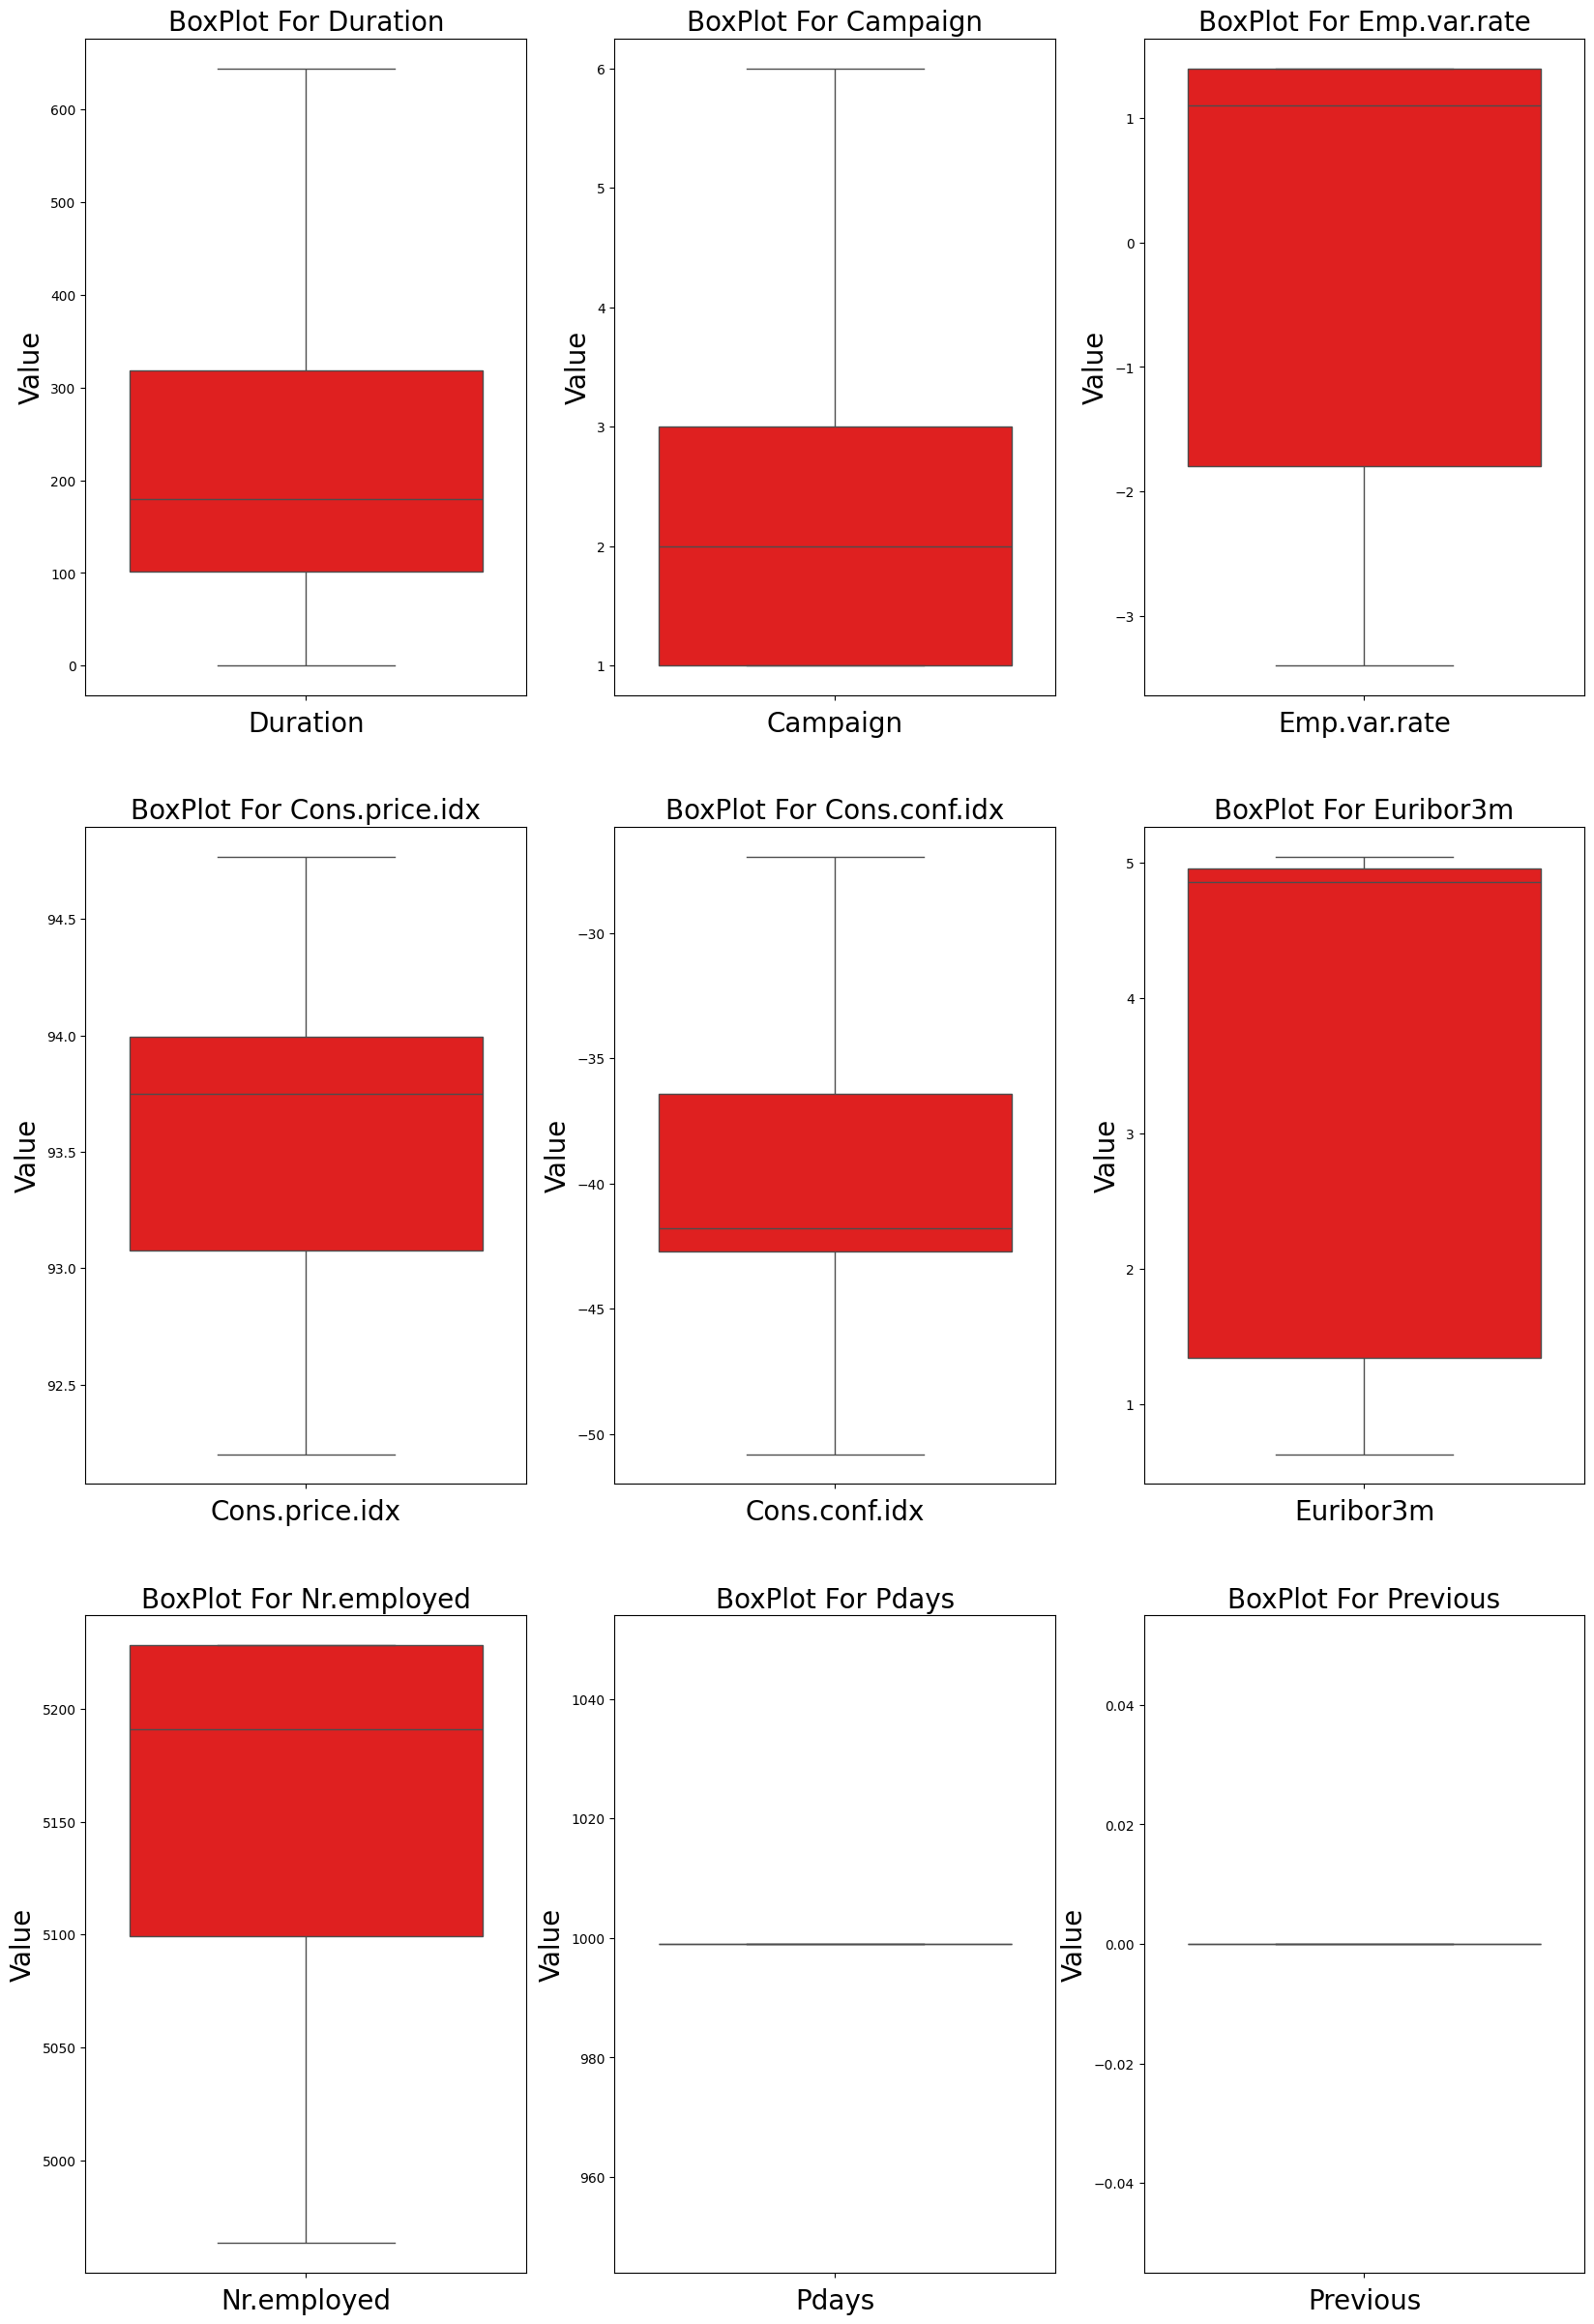

In [ ]:
plt.figure(figsize=(20,30))
for i,x in enumerate(li):
    plt.subplot(3,3,i+1)
    sns.boxplot(data=data[x],color='r')
    plt.title(f'BoxPlot For {x[0].upper()+x[1:]}',fontsize=20)
    plt.xlabel(f'{x[0].upper()+x[1:]}',fontsize=20)
    plt.ylabel('Value',fontsize=20)

In [ ]:
X=data.iloc[:,:-1]
y=data.iloc[:,-1]
key=X.keys()
X

,age,job,marital,education,default,housing,loan,contact,month,day_of_week,duration,campaign,pdays,previous,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed
0,56.0,housemaid,married,basic.4y,no,no,no,telephone,may,mon,261.0,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0
1,57.0,services,married,high.school,unknown,no,no,telephone,may,mon,149.0,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0
2,37.0,services,married,high.school,no,yes,no,telephone,may,mon,226.0,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0
3,40.0,admin.,married,basic.6y,no,no,no,telephone,may,mon,151.0,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0
4,56.0,services,married,high.school,no,no,yes,telephone,may,mon,307.0,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
41183,69.5,retired,married,professional.course,no,yes,no,cellular,nov,fri,334.0,1,999,0,nonexistent,-1.1,94.767,-50.8,1.028,4963.6
41184,46.0,blue-collar,married,professional.course,no,no,no,cellular,nov,fri,383.0,1,999,0,nonexistent,-1.1,94.767,-50.8,1.028,4963.6
41185,56.0,retired,married,university.degree,no,yes,no,cellular,nov,fri,189.0,2,999,0,nonexistent,-1.1,94.767,-50.8,1.028,4963.6
41186,44.0,technician,married,professional.course,no,no,no,cellular,nov,fri,442.0,1,999,0,nonexistent,-1.1,94.767,-50.8,1.028,4963.6


In [ ]:
y

0         no
1         no
2         no
3         no
4         no
        ... 
41183    yes
41184     no
41185     no
41186    yes
41187     no
Name: y, Length: 41176, dtype: object

In [ ]:
y.replace('no',0,inplace=True)
y.replace('yes',1,inplace=True)
y

0        0
1        0
2        0
3        0
4        0
        ..
41183    1
41184    0
41185    0
41186    1
41187    0
Name: y, Length: 41176, dtype: int64

In [ ]:
'''X=pd.get_dummies(X)
key=X.keys()
X'''
label=LabelEncoder()
for i in X.select_dtypes(include='object').columns:
    X[i]=label.fit_transform(X[i])
X

,age,job,marital,education,default,housing,loan,contact,month,day_of_week,duration,campaign,pdays,previous,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed
0,56.0,3,1,0,0,0,0,1,6,1,261.0,1,999,0,1,1.1,93.994,-36.4,4.857,5191.0
1,57.0,7,1,3,1,0,0,1,6,1,149.0,1,999,0,1,1.1,93.994,-36.4,4.857,5191.0
2,37.0,7,1,3,0,2,0,1,6,1,226.0,1,999,0,1,1.1,93.994,-36.4,4.857,5191.0
3,40.0,0,1,1,0,0,0,1,6,1,151.0,1,999,0,1,1.1,93.994,-36.4,4.857,5191.0
4,56.0,7,1,3,0,0,2,1,6,1,307.0,1,999,0,1,1.1,93.994,-36.4,4.857,5191.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
41183,69.5,5,1,5,0,2,0,0,7,0,334.0,1,999,0,1,-1.1,94.767,-50.8,1.028,4963.6
41184,46.0,1,1,5,0,0,0,0,7,0,383.0,1,999,0,1,-1.1,94.767,-50.8,1.028,4963.6
41185,56.0,5,1,6,0,2,0,0,7,0,189.0,2,999,0,1,-1.1,94.767,-50.8,1.028,4963.6
41186,44.0,9,1,5,0,0,0,0,7,0,442.0,1,999,0,1,-1.1,94.767,-50.8,1.028,4963.6


In [ ]:
min_max=MinMaxScaler()
X=min_max.fit_transform(X)
X=pd.DataFrame(X,columns=key)
X

,age,job,marital,education,default,housing,loan,contact,month,day_of_week,duration,campaign,pdays,previous,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed
0,0.742857,0.272727,0.333333,0.000000,0.0,0.0,0.0,1.0,0.666667,0.25,0.404965,0.0,0.0,0.0,0.5,0.937500,0.698753,0.603774,0.957379,0.859735
1,0.761905,0.636364,0.333333,0.428571,0.5,0.0,0.0,1.0,0.666667,0.25,0.231187,0.0,0.0,0.0,0.5,0.937500,0.698753,0.603774,0.957379,0.859735
2,0.380952,0.636364,0.333333,0.428571,0.0,1.0,0.0,1.0,0.666667,0.25,0.350659,0.0,0.0,0.0,0.5,0.937500,0.698753,0.603774,0.957379,0.859735
3,0.438095,0.000000,0.333333,0.142857,0.0,0.0,0.0,1.0,0.666667,0.25,0.234290,0.0,0.0,0.0,0.5,0.937500,0.698753,0.603774,0.957379,0.859735
4,0.742857,0.636364,0.333333,0.428571,0.0,0.0,1.0,1.0,0.666667,0.25,0.476338,0.0,0.0,0.0,0.5,0.937500,0.698753,0.603774,0.957379,0.859735
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
41171,1.000000,0.454545,0.333333,0.714286,0.0,1.0,0.0,0.0,0.777778,0.00,0.518231,0.0,0.0,0.0,0.5,0.479167,1.000000,0.000000,0.089322,0.000000
41172,0.552381,0.090909,0.333333,0.714286,0.0,0.0,0.0,0.0,0.777778,0.00,0.594259,0.0,0.0,0.0,0.5,0.479167,1.000000,0.000000,0.089322,0.000000
41173,0.742857,0.454545,0.333333,0.857143,0.0,1.0,0.0,0.0,0.777778,0.00,0.293251,0.2,0.0,0.0,0.5,0.479167,1.000000,0.000000,0.089322,0.000000
41174,0.514286,0.818182,0.333333,0.714286,0.0,0.0,0.0,0.0,0.777778,0.00,0.685803,0.0,0.0,0.0,0.5,0.479167,1.000000,0.000000,0.089322,0.000000


,age,job,marital,education,default,housing,loan,contact,month,day_of_week,...,campaign,pdays,previous,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,y
age,1.000000,-0.001473,-0.393867,-0.114950,0.171183,-0.002119,-0.007786,0.012050,-0.027142,-0.019257,...,0.003337,NaN,NaN,0.018387,0.012335,0.006923,0.126550,0.024153,-0.002228,0.029239
job,-0.001473,1.000000,0.027829,0.134159,-0.028282,0.006873,-0.010161,-0.025054,-0.033007,-0.000868,...,-0.006669,NaN,NaN,0.011485,-0.008443,-0.016122,0.052799,-0.008024,-0.019728,0.032469
marital,-0.393867,0.027829,1.000000,0.109195,-0.079432,0.010499,0.005806,-0.054527,-0.007622,0.002174,...,-0.010507,NaN,NaN,0.001905,-0.084142,-0.057431,-0.033845,-0.091881,-0.086134,0.037242
education,-0.114950,0.134159,0.109195,1.000000,-0.186811,0.016891,0.006441,-0.105722,-0.082739,-0.017989,...,0.002417,NaN,NaN,0.016987,-0.043695,-0.081499,0.078807,-0.036321,-0.041455,0.054938
default,0.171183,-0.028282,-0.079432,-0.186811,1.000000,-0.015790,-0.003823,0.135275,-0.015787,-0.008660,...,0.037022,NaN,NaN,0.023437,0.203257,0.168076,0.026563,0.195335,0.189846,-0.088652
housing,-0.002119,0.006873,0.010499,0.016891,-0.015790,1.000000,0.044272,-0.082098,-0.018050,0.003339,...,-0.010862,NaN,NaN,-0.011771,-0.060248,-0.080579,-0.033678,-0.059283,-0.045892,0.011730
loan,-0.007786,-0.010161,0.005806,0.006441,-0.003823,0.044272,1.000000,-0.008589,-0.005738,-0.009345,...,0.011664,NaN,NaN,-0.001486,0.001840,-0.002474,-0.011997,0.000125,0.003910,-0.007864
contact,0.012050,-0.025054,-0.054527,-0.105722,0.135275,-0.082098,-0.008589,1.000000,0.276499,-0.009614,...,0.071645,NaN,NaN,0.118773,0.393730,0.591596,0.251719,0.399892,0.269285,-0.118786
month,-0.027142,-0.033007,-0.007622,-0.082739,-0.015787,-0.018050,-0.005738,0.276499,1.000000,0.027683,...,-0.063803,NaN,NaN,-0.065010,-0.178724,-0.004183,0.009364,-0.117216,-0.221370,-0.005420
day_of_week,-0.019257,-0.000868,0.002174,-0.017989,-0.008660,0.003339,-0.009345,-0.009614,0.027683,1.000000,...,-0.051014,NaN,NaN,0.018733,0.033288,0.005674,0.041412,0.039064,0.028414,0.003613


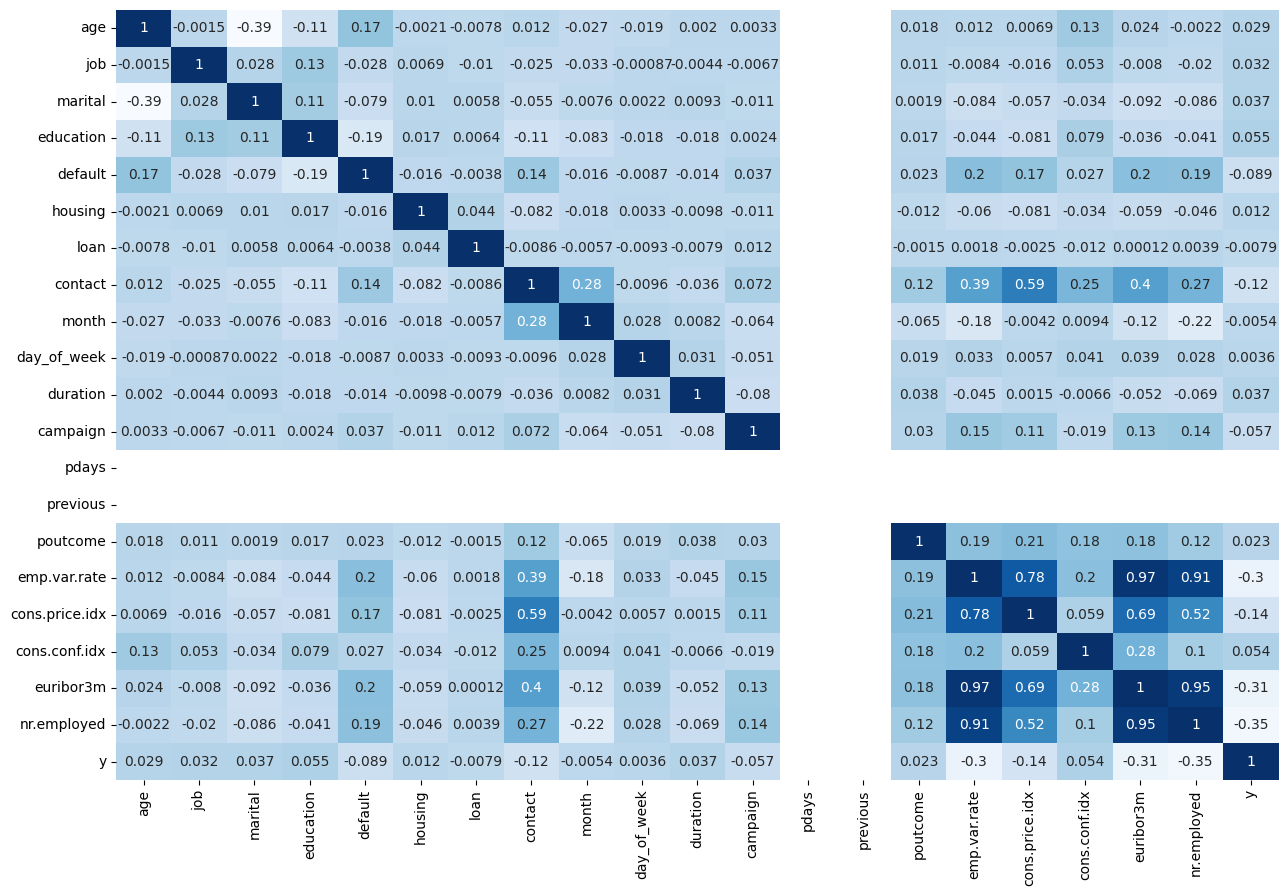

In [ ]:
data2=X.copy()
data2['y']=y.copy()
plt.figure(figsize=(15,10))
sns.heatmap(data2.corr(),cbar=False,cmap='Blues',annot=True)
data2.corr()

In [ ]:
X_train,X_test,y_train,y_test=train_test_split(X,y,test_size=.2,shuffle=True,random_state=44)
print('X_train shape',X_train.shape)
print('X_test shape',X_test.shape)
print('y_train shape',y_train.shape)
print('y_test shape',y_test.shape)

X_train shape (32940, 20)
X_test shape (8236, 20)
y_train shape (32940,)
y_test shape (8236,)


In [ ]:
X_test,X_val,y_test,y_val=train_test_split(X_test,y_test,test_size=.25,shuffle=True,random_state=44)
print('X_test shape',X_test.shape)
print('X_val shape',X_val.shape)
print('y_test shape',y_test.shape)
print('y_val shape',y_val.shape)

X_test shape (6177, 20)
X_val shape (2059, 20)
y_test shape (6177,)
y_val shape (2059,)


In [ ]:
model=keras.models.Sequential()
model.add(keras.layers.Dense(128,input_shape=(X.shape[1],),activation='relu',name='Dense_Layer1'))
model.add(keras.layers.Dense(256,activation='relu',name='Dense_Layer2'))
model.add(keras.layers.Dense(1,activation='sigmoid',name='Dense_Layer3'))

In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Dense_Layer1 (Dense)        (None, 128)               2688      
                                                                 
 Dense_Layer2 (Dense)        (None, 256)               33024     
                                                                 
 Dense_Layer3 (Dense)        (None, 1)                 257       
                                                                 
Total params: 35969 (140.50 KB)
Trainable params: 35969 (140.50 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [ ]:
model.compile(optimizer ='adam',loss='binary_crossentropy',metrics=['accuracy'])
checkpoint_cb =keras.callbacks.ModelCheckpoint("my_keras_model.h5", save_best_only=True)
early_stopping_cb =keras.callbacks.EarlyStopping(patience=10, restore_best_weights=True)
hist=model.fit(X_train, y_train, epochs=30,validation_data=(X_val,y_val),batch_size=64,
         callbacks=[checkpoint_cb, early_stopping_cb])

Epoch 1/30
515/515 [==============================] - 4s 6ms/step - loss: 0.2222 - accuracy: 0.9031 - val_loss: 0.2135 - val_accuracy: 0.9019
Epoch 2/30
 55/515 [==>...........................] - ETA: 1s - loss: 0.2007 - accuracy: 0.9048

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


515/515 [==============================] - 2s 3ms/step - loss: 0.1984 - accuracy: 0.9063 - val_loss: 0.2053 - val_accuracy: 0.9029
Epoch 3/30
515/515 [==============================] - 2s 3ms/step - loss: 0.1961 - accuracy: 0.9071 - val_loss: 0.2134 - val_accuracy: 0.9034
Epoch 4/30
 90/515 [====>.........................] - ETA: 1s - loss: 0.1881 - accuracy: 0.9123

In [ ]:
loss,acc=model.evaluate(X_test,y_test)
print('Test Loss :',loss)
print('Test accuracy :',acc)

In [ ]:
hist_=pd.DataFrame(hist.history)
hist_

In [ ]:
plt.plot(hist_['accuracy'],label='accuracy')
plt.plot(hist_['val_accuracy'],label='val_accuracy')
plt.grid(True)
plt.ylabel('accuracy',fontsize=20)
plt.xlabel('Epoch',fontsize=20)
plt.title('accuracy vs. val_accuracy',fontsize=20)
plt.legend()
plt.show()

In [ ]:
plt.plot(hist_['loss'],label='Loss')
plt.plot(hist_['val_loss'],label='val_Loss')
plt.grid(True)
plt.ylabel('Loss',fontsize=20)
plt.xlabel('Epoch',fontsize=20)
plt.title('Loss vs. val_Loss',fontsize=20)
plt.legend()
plt.show()

In [ ]:
pred=model.predict(X_test)
y_pred=np.where(pred>=.5,1,0)

In [ ]:
df=pd.DataFrame()
df['Actual'],df['Predicted']=y_test,y_pred
df

In [ ]:
CM = confusion_matrix(y_test, y_pred)
sns.heatmap(CM,annot=True,fmt='g',center = True,cmap='Blues_r')
plt.show()
CM

In [ ]:
ClassificationReport = classification_report(y_test,y_pred)
print('Classification Report is : ', ClassificationReport )

The Dataset imblanced

In [ ]:
#over
over=RandomOverSampler(random_state=44)
X_train_over, y_train_over = over.fit_resample(X_train, y_train)
y_train_over.value_counts()

In [ ]:
model.compile(optimizer ='adam',loss='binary_crossentropy',metrics=['accuracy'])
checkpoint_cb =keras.callbacks.ModelCheckpoint("my_keras_model_over.h5", save_best_only=True)
early_stopping_cb =keras.callbacks.EarlyStopping(patience=10, restore_best_weights=True)
hist=model.fit(X_train_over, y_train_over, epochs=30,validation_data=(X_val,y_val),batch_size=64,
         callbacks=[checkpoint_cb, early_stopping_cb])

In [ ]:
loss,acc=model.evaluate(X_test,y_test)
print('Test Loss :',loss)
print('Test accuracy :',acc)

In [ ]:
hist_=pd.DataFrame(hist.history)
hist_

In [ ]:
plt.plot(hist_['accuracy'],label='accuracy')
plt.plot(hist_['val_accuracy'],label='val_accuracy')
plt.grid(True)
plt.ylabel('accuracy',fontsize=20)
plt.xlabel('Epoch',fontsize=20)
plt.title('accuracy vs. val_accuracy',fontsize=20)
plt.legend()
plt.show()

In [ ]:
plt.plot(hist_['loss'],label='Loss')
plt.plot(hist_['val_loss'],label='val_Loss')
plt.grid(True)
plt.ylabel('Loss',fontsize=20)
plt.xlabel('Epoch',fontsize=20)
plt.title('Loss vs. val_Loss',fontsize=20)
plt.legend()
plt.show()

In [ ]:
pred=model.predict(X_test)
y_pred=np.where(pred>=.5,1,0)

In [ ]:
df=pd.DataFrame()
df['Actual'],df['Predicted']=y_test,y_pred
df

In [ ]:
CM = confusion_matrix(y_test, y_pred)
sns.heatmap(CM,annot=True,fmt='g',center = True,cmap='Blues_r')
plt.show()
CM

In [ ]:
ClassificationReport = classification_report(y_test,y_pred)
print('Classification Report is : ', ClassificationReport )

In [ ]:
#under
under=RandomUnderSampler(random_state=44)
X_train_under, y_train_under = under.fit_resample(X_train, y_train)
y_train_under.value_counts()

In [ ]:
model.compile(optimizer ='adam',loss='binary_crossentropy',metrics=['accuracy'])
checkpoint_cb =keras.callbacks.ModelCheckpoint("my_keras_model_under.h5", save_best_only=True)
early_stopping_cb =keras.callbacks.EarlyStopping(patience=10, restore_best_weights=True)
hist=model.fit(X_train_under, y_train_under, epochs=30,validation_data=(X_val,y_val),batch_size=64,
         callbacks=[checkpoint_cb, early_stopping_cb])

In [ ]:
loss,acc=model.evaluate(X_test,y_test)
print('Test Loss :',loss)
print('Test accuracy :',acc)

In [ ]:
hist_=pd.DataFrame(hist.history)
hist_

In [ ]:
plt.plot(hist_['accuracy'],label='accuracy')
plt.plot(hist_['val_accuracy'],label='val_accuracy')
plt.grid(True)
plt.ylabel('accuracy',fontsize=20)
plt.xlabel('Epoch',fontsize=20)
plt.title('accuracy vs. val_accuracy',fontsize=20)
plt.legend()
plt.show()

In [ ]:
plt.plot(hist_['loss'],label='Loss')
plt.plot(hist_['val_loss'],label='val_Loss')
plt.grid(True)
plt.ylabel('Loss',fontsize=20)
plt.xlabel('Epoch',fontsize=20)
plt.title('Loss vs. val_Loss',fontsize=20)
plt.legend()
plt.show()

In [ ]:
pred=model.predict(X_test)
y_pred=np.where(pred>=.5,1,0)

In [ ]:
df=pd.DataFrame()
df['Actual'],df['Predicted']=y_test,y_pred
df

In [ ]:
CM = confusion_matrix(y_test, y_pred)
sns.heatmap(CM,annot=True,fmt='g',center = True,cmap='Blues_r')
plt.show()
CM

In [ ]:
ClassificationReport = classification_report(y_test,y_pred)
print('Classification Report is : ', ClassificationReport )